In [53]:
# # EVALution 1.0
# Dataset containing Semantic Relations and Metadata, for Training and Evaluating Distributional Semantic Models
# The resource is freely available. If you use it, please cite the description paper:
# - Enrico Santus, Frances Yung, Alessandro Lenci, and Chu-Ren Huang. 2015. EVALution 1.0: An Evolving Semantic Dataset for Training and Evaluation of Distributional Semantic Models. Proceedings of the 4th Workshop on Linked Data in Linguistics, Beijing.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [55]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
# from tensorflow.keras.utils import plot_model
# import keras_tqdm
# from livelossplot.keras import PlotLossesCallback

In [56]:
# custom layers from external files
from layers.embeddings import ElmoLayer
from layers.attention import AttentionLayer
from models.build_models import build_model_elmo, initialize_vars
from models.train_models import *
from utils.utils import *

In [57]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data 

In [58]:
# collum descriptions::
#  - first relatum: it is one of the relata in the file RELATA.txt
#  - relation: it can be one of the following relations: Antonym, Synonym, IsA (hypernymy), PartOf (meronymy), MemberOf (meronymy), MadeOf (meronymy), Entailment, HasA (possession), HasProperty (attribute). For the definition of these relations, please refer to: https://github.com/commonsense/conceptnet5/wiki/Relations.
#  - second relatum: it is one of the relata in the file RELATA.txt
#  - tags: this field contains a comma separated list of tags, with their frequency among the total number of annotators (e.g. "CULTURE_1/5,EVENT_4/5" stays for CULTURE was tagged by 1 subject on 5, while PLANT by 4 on 5). NOTE: The reliability of the tags is slow, as some subjects have tried to cheat; we suggest you to rely on tags that were judged at least twice.
#  - sentence: this field contains a sentence that paraphrases the relation; this sentence was used in the crowdsourcing task to assess the quality of the relation.
#  - distribution of votes: the next five columns are integers that represent the number of votes for each value, with reference to the sentence in the previous field: "strong disagreement" (the first one, value=1), "disagreement", "neutral", "agreement" and "strong agreement" (the last one, value=5).
#  - agreement between subjects as reported by Crowdflower.
#  - number of subjects who voted the agreement with the sentence.
#  - average score (in the range between 1="strongly disagree" and 5="strongly agree").
#  - variance among the votes.
#  - average score minus the variance.
#  - source from which the pair was extracted.
#  - score in the source, if available.
eval_colnames = [
    "relata1",
    "relation",
    "relata2",
    "tags",
    "sentence",
    "votes_sc_1",
    "votes_sc_2",
    "votes_sc_3",
    "votes_sc_4",
    "votes_sc_5",
    "votes_agreement",
    "votes_no_agree",
    "votes_avg_score",
    "votes_var_score",
    "votes_avg_var_diff",
    "pair_source_name",
    "pair_source_score"
]

In [59]:
df_eval = pd.read_table("dataset/EVALution_1.0/RELATIONS.txt", sep="\t", header=None, names=eval_colnames, index_col=False)

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [60]:
df_eval['sentence'] = df_eval['sentence'].str.lower()

In [61]:
df_eval.head(10)

,relata1,relation,relata2,tags,sentence,votes_sc_1,votes_sc_2,votes_sc_3,votes_sc_4,votes_sc_5,votes_agreement,votes_no_agree,votes_avg_score,votes_var_score,votes_avg_var_diff,pair_source_name,pair_source_score
0,abstract,Antonym,concrete,"OBJECT_3/5,EMOTION_2/5,EVENT_2/5,RELATIONSHIP_1/5",abstract can be used as the opposite of concrete,0,0,0,3,2,0.912340,5,4.400000,0.300000,4.100000,wordnet/4.0,score
1,accident,Antonym,plan,"CULTURE_1/5,EVENT_4/5",accident can be used as the opposite of plan,0,0,0,12,26,0.953509,38,4.684211,0.221906,4.462304,verbosity,0.0445190226130131
2,accident,Antonym,purpose,EVENT_5/5,accident can be used as the opposite of purpose,0,0,0,3,2,0.913917,5,4.400000,0.300000,4.100000,verbosity,0.13952094877868304
3,accident,Synonym,event,EVENT_5/5,accident can be used with the same meaning of event,0,0,1,3,1,0.935375,5,4.000000,0.500000,3.500000,wiktionary/de/en,1.0
4,accident,IsA,error,"EVENT_4/5,RELATIONSHIP_1/5",accident is a kind of error,0,0,0,2,3,0.911600,5,4.600000,0.300000,4.300000,conceptnet/4/en,1.5849625007211563
5,accident,IsA,happen,EVENT_5/5,accident is a kind of happen,0,0,0,2,3,0.965458,5,4.600000,0.300000,4.300000,wordnet/3.0,1.5849625007211563
6,accident,IsA,mistake,"RELATIONSHIP_1/60,NATURE_1/60,FOOD_1/60,COMMUNICATION_2/60,OBJECT_3/60,CULTURE_2/60,EVENT_57/60",accident is a kind of mistake,0,0,0,2,3,0.954483,5,4.600000,0.300000,4.300000,conceptnet/4/en,1.5849625007211563
7,account,Synonym,record,"OBJECT_2/5,CULTURE_1/5,EVENT_2/5,BUSINESS_2/5",account can be used with the same meaning of record,0,0,0,2,3,0.908725,5,4.600000,0.300000,4.300000,wiktionary/de/en,1.0
8,account,Synonym,report,"EVENT_3/5,BUSINESS_2/5,NATURE_1/5",account can be used with the same meaning of report,0,0,0,2,3,0.967600,5,4.600000,0.300000,4.300000,wiktionary/de/en,1.0
9,account,Synonym,score,"OBJECT_2/6,EVENT_6/6,BUSINESS_1/6,NATURE_1/6",account can be used with the same meaning of score,0,1,0,2,2,0.962425,5,4.000000,1.500000,2.500000,wiktionary/de/en,1.0


In [62]:
df_eval[df_eval['relation']=='MadeOf'].sample(10)

,relata1,relation,relata2,tags,sentence,votes_sc_1,votes_sc_2,votes_sc_3,votes_sc_4,votes_sc_5,votes_agreement,votes_no_agree,votes_avg_score,votes_var_score,votes_avg_var_diff,pair_source_name,pair_source_score
2637,fence,MadeOf,metal,"OBJECT_5/5,CULTURE_1/5,NATURE_1/5",fence is made of metal,0,0,0,3,2,0.921050,5,4.4,0.3,4.1,conceptnet/4/en,1.5849625007211563
6776,tax,MadeOf,money,"BUSINESS_4/5,RELATIONSHIP_1/5,OBJECT_1/5,CULTURE_1/5,EVENT_1/5",tax is made of money,0,0,0,2,3,0.949058,5,4.6,0.3,4.3,conceptnet/4/en,1.5849625007211563
477,beach,MadeOf,sand,"EMOTION_1/3,CULTURE_1/3,BUSINESS_1/3,RELATIONSHIP_1/3,SPACE_1/3,FOOD_1/3,COMMUNICATION_1/3,OBJECT_1/3,COLOR_1/3,TIME_1/3,NATURE_3/3,EVENT_1/3",beach is made of sand,0,0,0,1,4,0.949180,5,4.8,0.2,4.6,conceptnet/4/en,1.5849625007211563
914,brick,MadeOf,clay,"OBJECT_4/5,NATURE_2/5",brick is made of clay,0,0,0,5,0,0.968583,5,4.0,0.0,4.0,conceptnet/4/en,2.321928094887362
1485,coffee,MadeOf,bean,"OBJECT_2/5,FOOD_4/5,NATURE_1/5",coffee is made of bean,0,0,0,0,5,0.919658,5,5.0,0.0,5.0,globalmind,2.0
3796,jar,MadeOf,glass,"EMOTION_1/5,CULTURE_1/5,BUSINESS_1/5,RELATIONSHIP_3/5,SPACE_1/5,FOOD_1/5,COMMUNICATION_1/5,OBJECT_5/5,COLOR_1/5,TIME_1/5,NATURE_1/5,EVENT_1/5",jar is made of glass,0,0,0,0,5,0.961400,5,5.0,0.0,5.0,conceptnet/4/en,2.321928094887362
2034,die,MadeOf,wood,"OBJECT_5/5,NATURE_1/5",die is made of wood,2,0,0,3,0,0.957042,5,2.8,2.7,0.1,conceptnet/4/en,0.0
515,bed_sheet,MadeOf,cloth,OBJECT_5/5,bed_sheet is made of cloth,0,0,0,0,5,0.932500,5,5.0,0.0,5.0,conceptnet/4/en,1.5849625007211563
7070,tv,MadeOf,metal,OBJECT_7/7,tv is made of metal,0,1,0,4,0,0.955600,5,3.6,0.8,2.8,globalmind,2.0
6293,snowflake,MadeOf,water,"EMOTION_1/5,CULTURE_1/5,BUSINESS_1/5,RELATIONSHIP_1/5,SPACE_1/5,FOOD_1/5,COMMUNICATION_1/5,OBJECT_3/5,COLOR_1/5,TIME_1/5,NATURE_5/5,EVENT_1/5",snowflake is made of water,0,0,0,0,5,0.950708,5,5.0,0.0,5.0,wordnet/4.0,score


In [63]:
df_eval.shape

(7492, 17)

In [64]:
df_eval['relation'].value_counts()

IsA            1880
Antonym        1600
HasProperty    1297
Synonym        1086
PartOf         654 
HasA           544 
MadeOf         317 
Entails        82  
MemberOf       32  
Name: relation, dtype: int64

In [65]:
# maximum sentence length
max([len(sent.split()) for sent in df_eval['sentence']])

10

# Process input data

## target word and sentence inputs 

In [66]:
tt1 = ["this", 'is', 'a', 'test', 'sentence']
tt2 = ['is', 'a']
tt_ret = []
for x in tt2:
    for i, k in enumerate(tt1):
        if(x==k):
            tt_ret.append(i)
tt_ret

[1, 2]

In [67]:
[x.lower() for x in "test_this".split("_")]

['test', 'this']

In [68]:
MAX_SEQ_LEN = 30
MAX_SEQ_LEN_KAP_ELMO = 160
MAX_SEQ_LEN_KAP_BERT = 258

In [69]:
sentences_notarg = proc_sentences_EVALution(df_eval, 'sentence', 'relata1', 'relata2', 'relation', 
                                            False, MAX_SEQ_LEN, RELATIONAL_CUE_TOKENS)
sentences_wttarg = proc_sentences_EVALution(df_eval, 'sentence', 'relata1', 'relata2', 'relation', 
                                            True, MAX_SEQ_LEN, RELATIONAL_CUE_TOKENS)

In [70]:
sentences_notarg_long = proc_sentences_EVALution(df_eval, 'sentence', 'relata1', 'relata2', 'relation', 
                                            False, MAX_SEQ_LEN_KAP_ELMO, RELATIONAL_CUE_TOKENS)

In [71]:
# np.save(np.array(sentences_notarg), "evalution_sentences_notarg.npy")

In [72]:
sentences_bert = proc_sentences_dscovar(df_eval, 'sentence', 'relata1', 'bert', MAX_SEQ_LEN_KAP_BERT)

In [73]:
sentences_bert

[array(['abstract', 'accident', 'accident', ..., 'you', 'young', 'zero'],
       dtype='<U18'),
 array(['abstract can be used as the opposite of concrete',
        'accident can be used as the opposite of plan',
        'accident can be used as the opposite of purpose', ...,
        'you can have or can contain feel',
        'young can be used as the opposite of mature',
        'zero is a kind of number'], dtype='<U64')]

In [74]:
tokenizer = create_tokenizer_from_hub_module()
sentences_bert_examples = convert_text_to_examples(sentences_bert[0], sentences_bert[1], df_eval['votes_avg_score'])
sentences_bert_input = convert_examples_to_features(tokenizer, sentences_bert_examples, False, MAX_SEQ_LEN)
sentences_bert_input

(array([[ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        ...,
        [ 103, 1169, 1138, ...,    0,    0,    0],
        [ 103, 1169, 1129, ...,    0,    0,    0],
        [ 103, 1110,  170, ...,    0,    0,    0]]),
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([[4.4       ],
        [4.6842105

In [75]:
# tokenizer = create_tokenizer_from_hub_module()
# sentences_bert_examples = convert_text_to_examples(sentences_bert[0], sentences_bert[1], df_eval['votes_avg_score'])
sentences_bert_input_long = convert_examples_to_features(tokenizer, sentences_bert_examples, False, MAX_SEQ_LEN_KAP_BERT)

# Attention results scoring strategy

- processing the input
    - consider relata1 as the target word
    - sentence as a context
    - see if the model pays more attention to relata2
    - vice versa: this can control the target word location (beginning (relata1) or end (relata2) of the context sentence)
- scoring
    - (assuming relata1 is the target word)
    - criterion 1: does the model pays more attention to relata2?
    - criterion 2: does the model pays more attention to relational cues? 
        - e.g., abstract can be used as the *opposite* of concrete
    - sum the rankings 

# Model output 

In [76]:
K.clear_session()
sess = tf.Session()

# model_elmo_notune_wtattn = build_model_elmo(MAX_SEQ_LEN, False, True,  False)
# model_elmo_notune_noattn = build_model_elmo(MAX_SEQ_LEN, False, False, False)
model_elmo_fntune_wtattn_dsc = build_model_elmo(MAX_SEQ_LEN,  True, True, False, lr=1e-3)
model_elmo_fntune_wtattn_kap = build_model_elmo(MAX_SEQ_LEN_KAP_ELMO, True, True, False, lr=1e-3)
model_elmo_notune_wtattn_kap = build_model_elmo(MAX_SEQ_LEN_KAP_ELMO, False, True, False, lr=1e-3)
model_bert_fntune_wtattn_dsc = build_model_bert(MAX_SEQ_LEN,  True, True, False, lr=3e-5)
model_bert_fntune_wtattn_kap = build_model_bert(MAX_SEQ_LEN_KAP_BERT, True, True, False, lr=3e-5)
model_bert_notune_wtattn_kap = build_model_bert(MAX_SEQ_LEN_KAP_BERT, False, True, False, lr=3e-5)

initialize_vars(sess)

In [77]:
model_elmo_fntune_wtattn_dsc.load_weights('./model_weights/finetune/elmo/1emb/model_elmo_notarg_wtattn_bws_full_i5_b16_lr1e-03.tf')
model_elmo_fntune_wtattn_kap.load_weights('./model_weights_kapelner/elmo/1emb/model_elmo_notarg_wtattn_nocut_cv_full.tf')
model_elmo_notune_wtattn_kap.load_weights('./model_weights_kapelner/elmo/1emb/model_elmo_notune_notarg_wtattn_nocut_cv_full.tf')
model_bert_fntune_wtattn_dsc.load_weights('./model_weights/finetune/bert/1emb/model_bert_notarg_wtattn_bws_full_i5_b16_lr3e-05.tf')
model_bert_fntune_wtattn_kap.load_weights('./model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_nocut_full.tf')
model_bert_notune_wtattn_kap.load_weights('./model_weights_kapelner/bert/1emb/model_bert_notune_notarg_wtattn_nocut_full.tf')

In [78]:
model_elmo_fntune_attn_dsc = Model(model_elmo_fntune_wtattn_dsc.inputs, model_elmo_fntune_wtattn_dsc.get_layer("attention_sfmx_nrm").output)
model_elmo_fntune_attn_kap = Model(model_elmo_fntune_wtattn_kap.inputs, model_elmo_fntune_wtattn_kap.get_layer("attention_sfmx_nrm").output)
model_elmo_notune_attn_kap = Model(model_elmo_notune_wtattn_kap.inputs, model_elmo_notune_wtattn_kap.get_layer("attention_sfmx_nrm").output)
model_bert_fntune_attn_dsc = Model(model_bert_fntune_wtattn_dsc.inputs, model_bert_fntune_wtattn_dsc.get_layer("attention_sfmx_nrm").output)
model_bert_fntune_attn_kap = Model(model_bert_fntune_wtattn_kap.inputs, model_bert_fntune_wtattn_kap.get_layer("attention_sfmx_nrm").output)
model_bert_notune_attn_kap = Model(model_bert_notune_wtattn_kap.inputs, model_bert_notune_wtattn_kap.get_layer("attention_sfmx_nrm").output)

In [79]:
# elmo_fntune_attn_pred_dsc = np.transpose(model_elmo_fntune_attn_dsc.predict(sentences_notarg), axes=[0,2,1])[:, 0]
# elmo_fntune_attn_pred_kap = np.transpose(model_elmo_fntune_attn_kap.predict(sentences_notarg_long), axes=[0,2,1])[:, 0]
# elmo_notune_attn_pred_kap = np.transpose(model_elmo_notune_attn_kap.predict(sentences_notarg_long), axes=[0,2,1])[:, 0]
# bert_fntune_attn_pred_dsc = np.transpose(model_bert_fntune_attn_dsc.predict(sentences_bert_input), axes=[0,2,1])[:, 0]
# bert_fntune_attn_pred_kap = np.transpose(model_bert_fntune_attn_kap.predict(sentences_bert_input_long), axes=[0,2,1])[:, 0]
# bert_notune_attn_pred_kap = np.transpose(model_bert_notune_attn_kap.predict(sentences_bert_input_long), axes=[0,2,1])[:, 0]

# np.save("evalution_elmo_fntune_attn_pred_dsc.npy", elmo_fntune_attn_pred_dsc)
# np.save("evalution_elmo_fntune_attn_pred_kap.npy", elmo_fntune_attn_pred_kap)
# np.save("evalution_elmo_notune_attn_pred_kap.npy", elmo_notune_attn_pred_kap)
# np.save("evalution_bert_fntune_attn_pred_dsc.npy", bert_fntune_attn_pred_dsc)
# np.save("evalution_bert_fntune_attn_pred_kap.npy", bert_fntune_attn_pred_kap)
# np.save("evalution_bert_notune_attn_pred_kap.npy", bert_notune_attn_pred_kap)

In [80]:
elmo_fntune_attn_pred_dsc = np.load("evalution_elmo_fntune_attn_pred_dsc.npy")
elmo_fntune_attn_pred_kap = np.load("evalution_elmo_fntune_attn_pred_kap.npy")
elmo_notune_attn_pred_kap = np.load("evalution_elmo_notune_attn_pred_kap.npy")
bert_fntune_attn_pred_dsc = np.load("evalution_bert_fntune_attn_pred_dsc.npy")
bert_fntune_attn_pred_kap = np.load("evalution_bert_fntune_attn_pred_kap.npy")
bert_notune_attn_pred_kap = np.load("evalution_bert_notune_attn_pred_kap.npy")

Text(0.5,1,'bert_finetune_kapelner')

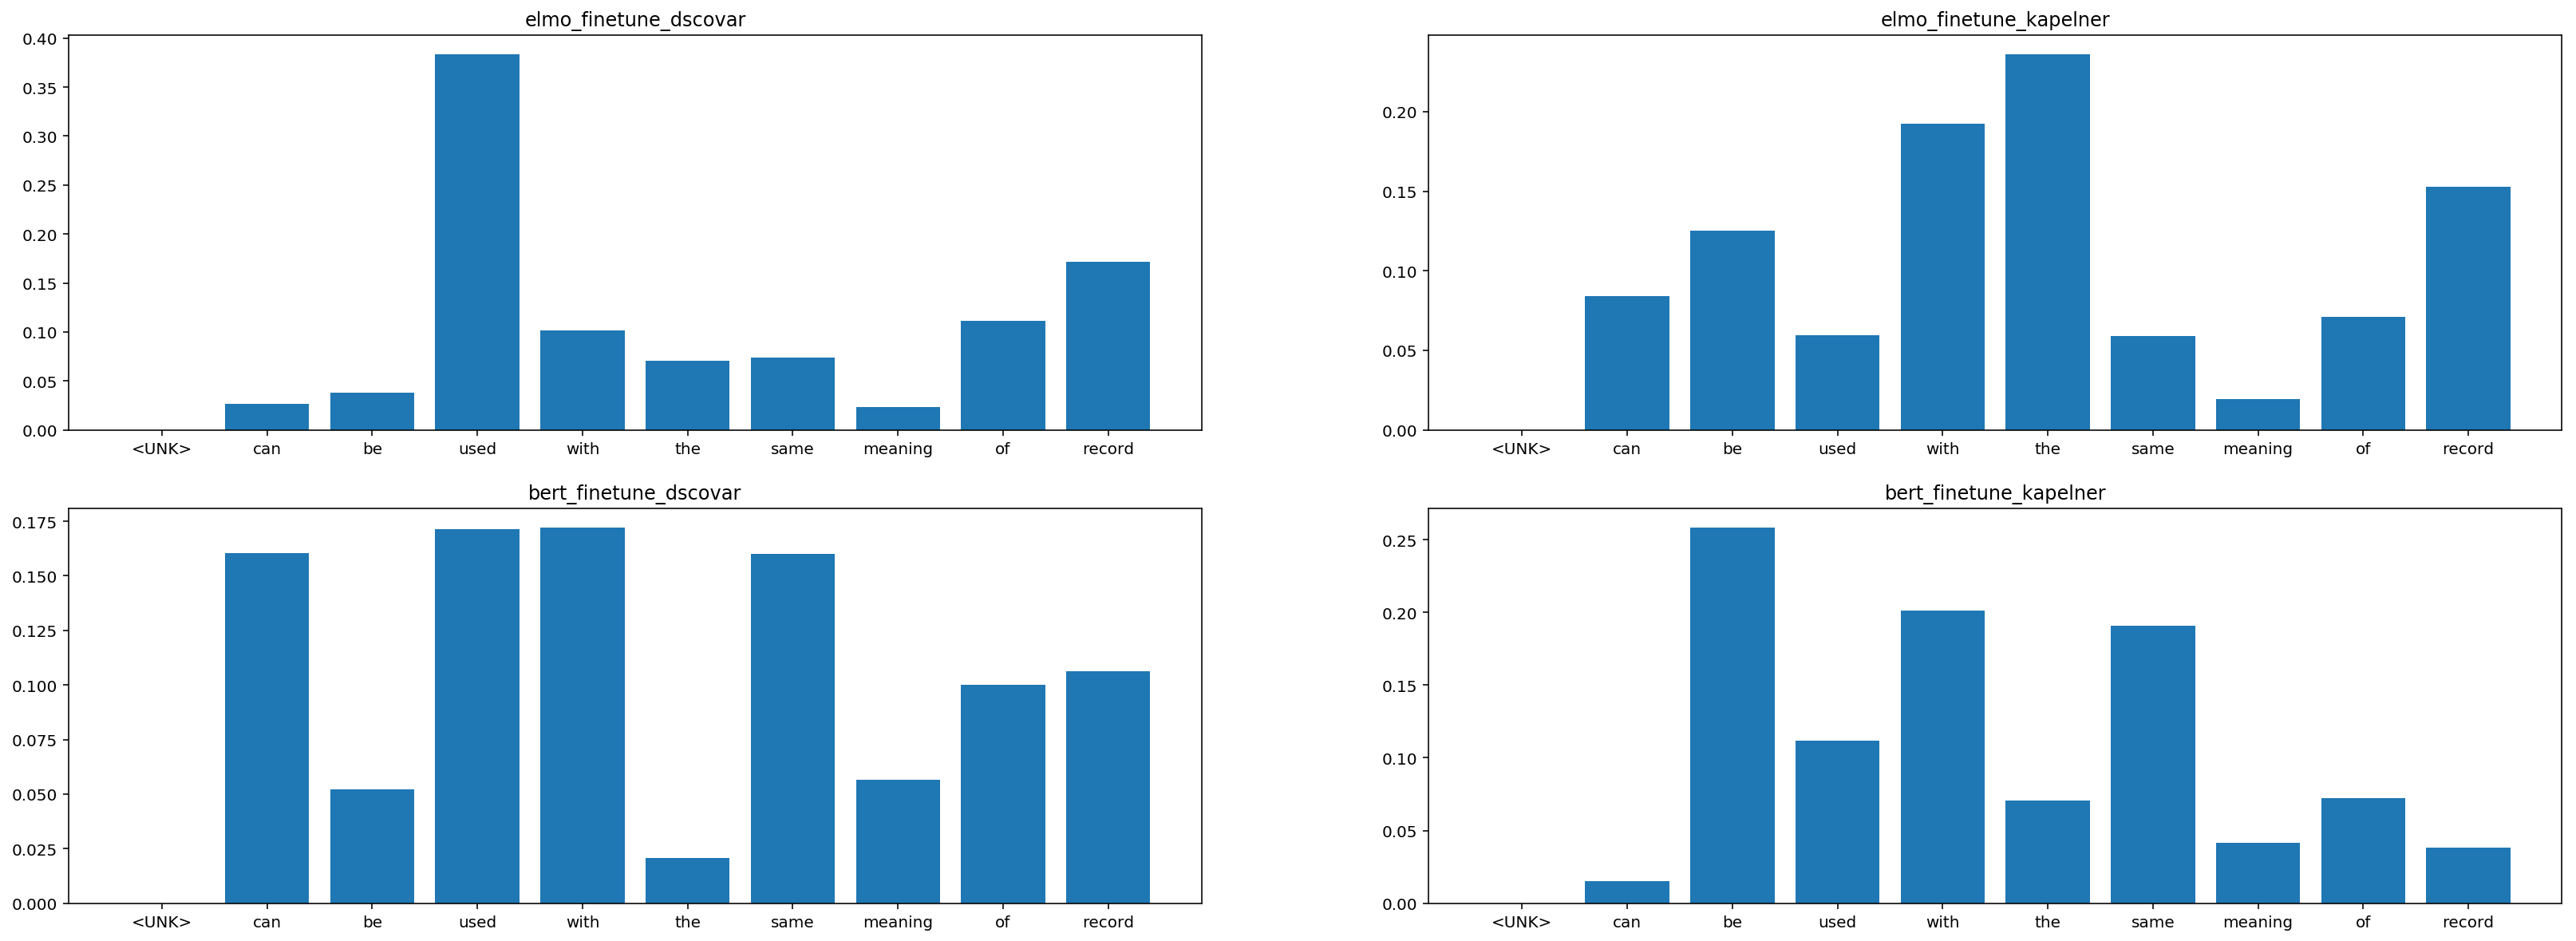

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(28, 10))

axes[0][0].bar(x=sentences_notarg[1][7][:10], height=elmo_fntune_attn_pred_dsc[7][:10]) #min_max_sc(elmo_fntune_attn_pred_dscovar[7] * sentences_notarg[2][7]))
axes[0][1].bar(x=sentences_notarg[1][7][:10], height=elmo_fntune_attn_pred_kap[7][:10]) #min_max_sc(elmo_fntune_attn_pred_kapelner[7] * sentences_notarg[2][7]))
axes[1][0].bar(x=sentences_notarg[1][7][:10], height=bert_fntune_attn_pred_dsc[7][:10]) #min_max_sc(bert_fntune_attn_pred_dscovar[7] * sentences_notarg[2][7]))
axes[1][1].bar(x=sentences_notarg[1][7][:10], height=bert_fntune_attn_pred_kap[7][:10]) #min_max_sc(bert_fntune_attn_pred_kapelner[7] * sentences_notarg[2][7]))

axes[0][0].set_title("elmo_finetune_dscovar")
axes[0][1].set_title("elmo_finetune_kapelner")
axes[1][0].set_title("bert_finetune_dscovar")
axes[1][1].set_title("bert_finetune_kapelner")


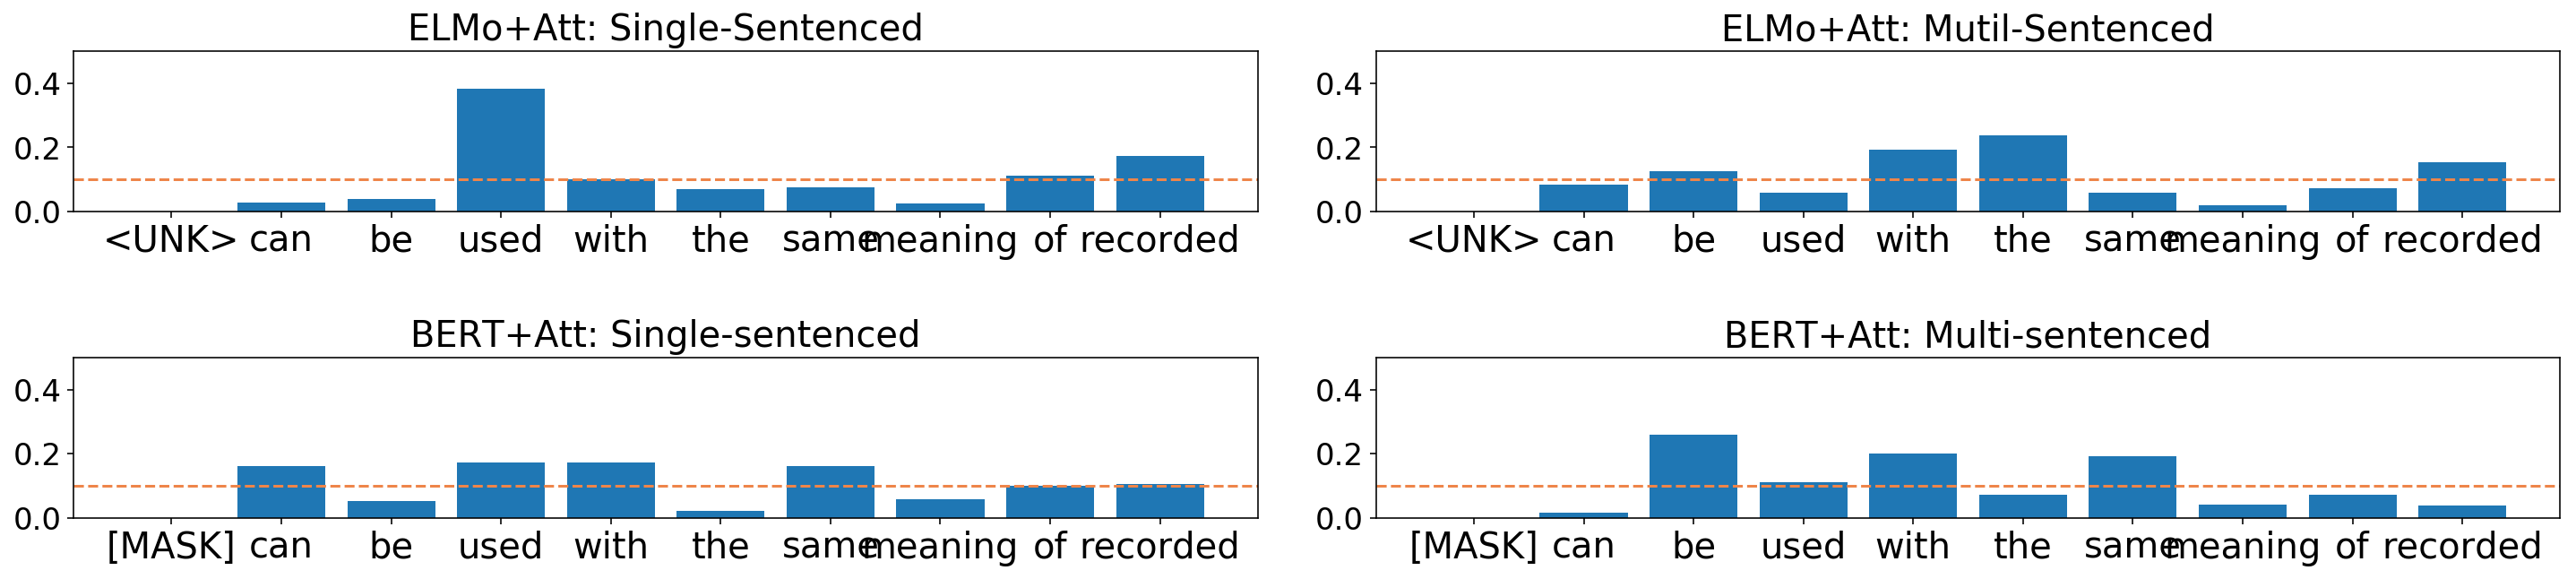

In [82]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(2, 2, figsize=(20, 2))
fig.tight_layout()
fig.subplots_adjust(top=2, wspace=0.1)

tt_idx=7

ax[0][0].bar(x=sentences_notarg[1][tt_idx][:10], height=elmo_fntune_attn_pred_dsc[tt_idx][:10]) #min_max_sc(elmo_fntune_attn_pred_dscovar[7] * sentences_notarg[2][7]))
ax[0][1].bar(x=sentences_notarg[1][tt_idx][:10], height=elmo_fntune_attn_pred_kap[tt_idx][:10]) #min_max_sc(elmo_fntune_attn_pred_kapelner[7] * sentences_notarg[2][7]))
ax[1][0].bar(x=sentences_notarg[1][tt_idx][:10], height=bert_fntune_attn_pred_dsc[tt_idx][:10]) #min_max_sc(bert_fntune_attn_pred_dscovar[7] * sentences_notarg[2][7]))
ax[1][1].bar(x=sentences_notarg[1][tt_idx][:10], height=bert_fntune_attn_pred_kap[tt_idx][:10]) #min_max_sc(bert_fntune_attn_pred_kapelner[7] * sentences_notarg[2][7]))

ax[0][0].set_title("ELMo+Att: Single-Sentenced", fontsize=20)
ax[0][1].set_title("ELMo+Att: Mutil-Sentenced", fontsize=20)
ax[1][0].set_title("BERT+Att: Single-sentenced", fontsize=20)
ax[1][1].set_title("BERT+Att: Multi-sentenced", fontsize=20)

colors = sns.color_palette('muted')
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylim(0, 0.5)
        ax[i][j].axhline(1/10, ls='--', color=colors[1])
        [ytick.label.set_fontsize(17) for ytick in ax[i][j].yaxis.get_major_ticks()]
        ax[i][j].set_ylabel("", fontsize=20)

        ax[i][j].set_xlabel("")
        
for j in range(2):
    ax[0][j].set_xticklabels(['<UNK>', 'can', 'be', 'used', 'with', 'the', 'same', 'meaning', 'of', 'recorded'], 
                             fontsize=20)
    ax[1][j].set_xticklabels(['[MASK]', 'can', 'be', 'used', 'with', 'the', 'same', 'meaning', 'of', 'recorded'], 
                             fontsize=20)

fig.savefig("result3_evaluation_synonym_app.pdf", dpi=300, bbox_inches = 'tight')


In [105]:
tt_df = pd.DataFrame({'sent':["We were not able to tell if the man was a  ______ or not .",
#                               "The swim team held extra practices before championships because winning was their ______ .",
                              "The barks and howls of dogs created too much ______ for us to sleep .",
                              # "They were once friends, but now there seems to be ______ between them .",
                              "______ can be used with the same meaning of record .", #syn
                              # "The child was ______ because she lied to her parents .", #causal
                              #"These are ______ , unlike the delicious ones we had yesterday .",
                              #"The world is full of ______ or pessimist ."
                             ],
                      'targ':['recluse',
#                               'incentive',
                              'din',
                              #'discord',
                              'Account',
#                               'punished',
                              #'sapid',
                              #'skeptics'
                      ],})
                              # "______ can be used as the opposite of mature .", young
                              # "______ can be used with the same meaning of record .", account
                              # "______ is a kind of number .", zero


In [106]:
tt_sent_elmo = proc_sentences_dscovar(tt_df, 'sent', None, 'elmo', MAX_SEQ_LEN)
tt_sent_bert = proc_sentences_dscovar(tt_df, 'sent', None, 'bert', MAX_SEQ_LEN_KAP_BERT)

In [107]:
tt_sent_bert_example = convert_text_to_examples(tt_sent_bert[0], tt_sent_bert[1], np.zeros(tt_df.shape[0]))
tt_sent_bert_input = convert_examples_to_features(tokenizer, tt_sent_bert_example, False, MAX_SEQ_LEN_KAP_BERT)

In [108]:
tt_attn_elmo = [np.reshape(model_elmo_fntune_attn_dsc.predict([[sent[i]] for sent in tt_sent_elmo]), -1) for i in range(tt_df.shape[0])] # np.transpose(model_elmo_fntune_attn_dsc.predict(tt_sent_elmo), axes=[0,2,1])[:, 0]
tt_attn_bert = [np.reshape(model_bert_fntune_attn_kap.predict([[sent[i]] for sent in tt_sent_bert_input]), -1) for i in range(tt_df.shape[0])] #np.transpose(model_bert_fntune_attn_kap.predict(tt_sent_bert_input), axes=[0,2,1])[:, 0]

In [109]:
tt_df_attn = []
for i in range(tt_df.shape[0]):
    sent = tt_sent_bert_input[0][i]
    sent_len = np.where(sent!=0)[0].max()
    tok = tokenizer.convert_ids_to_tokens(sent)[:sent_len]
    _df = pd.DataFrame({
#         'tok':tok,
        'tok_idx':[tok[idx]+"_"+str(idx) for idx in range(len(tok))],
#         'ELMo':tt_attn_elmo[i][:tt_sent_elmo[0][i]],
        'BERT_attn':tt_attn_bert[i][:sent_len], 
        'sent_len':sent_len,
        'sent_idx':i,
    })
    tok[tok.index('[MASK]')] = "("+tt_df.iloc[i]['targ']+")"
#     tok[tok.index('[MASK]')] = "______"
    _df['tok'] = tok
    
    tt_df_attn.append(_df)

tt_df_attn = pd.concat(tt_df_attn, axis=0)
# tt_df_attn = tt_df_attn.melt(id_vars=['sent_idx', 'sent_len', 'tok'])

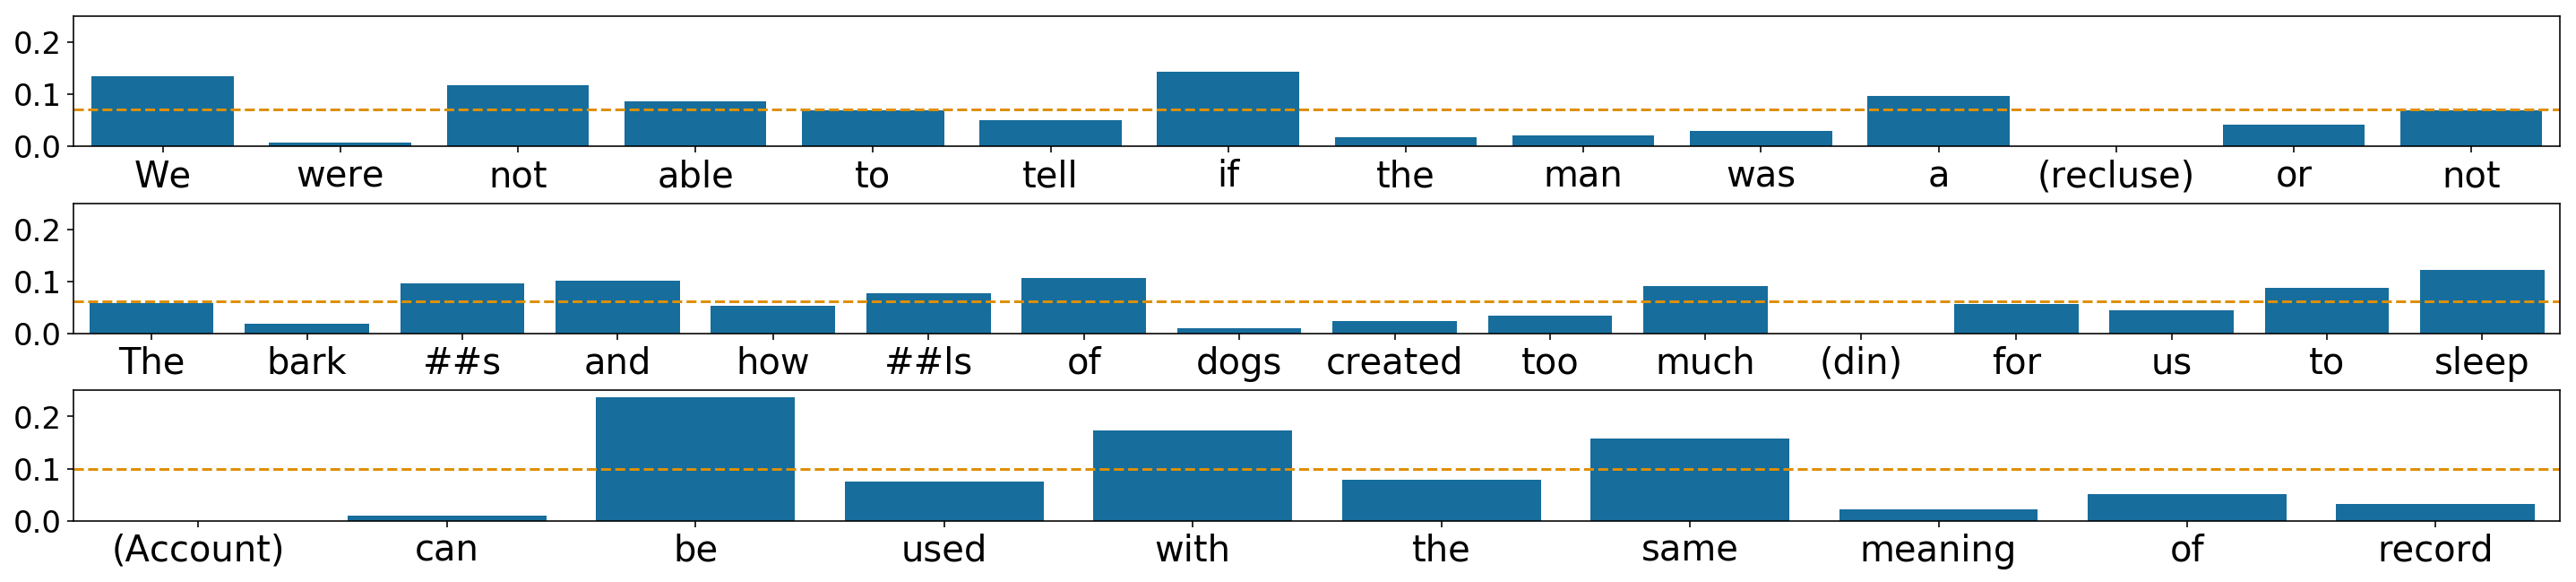

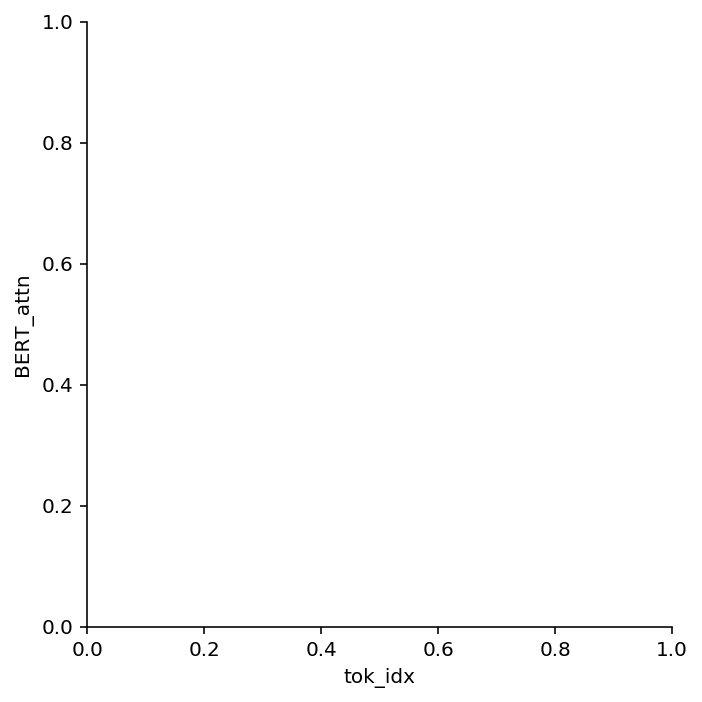

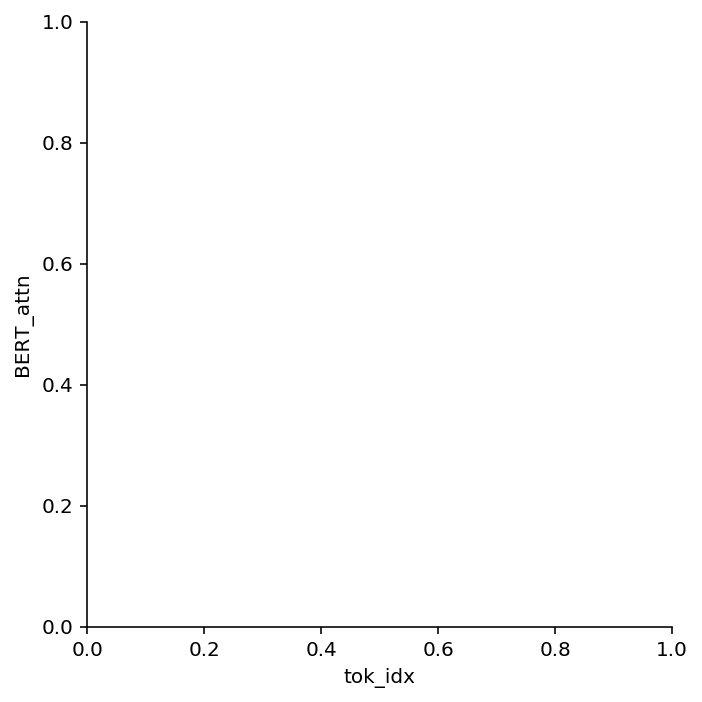

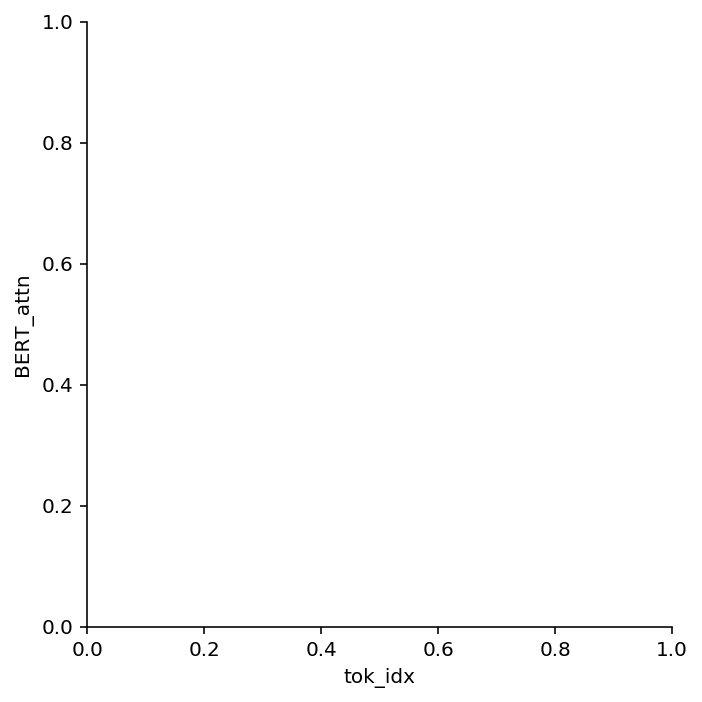

In [110]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(tt_df.shape[0], 1, figsize=(20, tt_df.shape[0]*1.5))
fig.tight_layout()
# fig.subplots_adjust(top=2, wspace=0.05)

colors = sns.color_palette('colorblind')

for i in range(tt_df.shape[0]):
    _df = tt_df_attn[tt_df_attn['sent_idx']==i]
    sns.catplot(x='tok_idx', y='BERT_attn', #hue='variable',
                kind="bar", #palette="muted",
                color=colors[0],
                data=_df,
                ax=ax[i])
    ax[i].set_ylim(0, 0.25)
    ax[i].axhline(1/_df.shape[0], ls='--', color=colors[1])
#     if(i < 2):
#         ax[i].set_ylim(0, 0.3)
#     else:
#         ax[i].set_ylim(0, 0.4)
    [ytick.label.set_fontsize(17) for ytick in ax[i].yaxis.get_major_ticks()]
    ax[i].set_ylabel("", fontsize=20)

    ax[i].set_xlabel("")
    ax[i].set_xticklabels(_df['tok'], fontsize=20)
    
# for i in range(2, 4):
#     sns.catplot(x='tok_idx', y='BERT_attn',
#                 kind="bar", palette="muted",
#                 data=tt_df_attn[tt_df_attn['sent_idx']==i],
#                 ax=ax[i])
#     ax[i].set_ylim(0, 0.5)
#     ax[i].set_xlabel("")
#     ax[i].set_ylabel("")
#     ax[i].set_xticklabels(tt_df_attn[tt_df_attn['sent_idx']==i]['tok'])
    
# ax[0].set_title("Synonym", fontsize=20)
# ax[1].set_title("Causal", fontsize=20)
# ax[2].set_title("Antonym", fontsize=20)

fig.savefig("result3_summary_examplesent.pdf", dpi=300, bbox_inches = 'tight')

In [89]:
tt_attn_bert_notune = [np.reshape(model_bert_notune_attn_kap.predict([[sent[i]] for sent in tt_sent_bert_input]), -1) for i in range(tt_df.shape[0])] #np.transpose(model_bert_fntune_attn_kap.predict(tt_sent_bert_input), axes=[0,2,1])[:, 0]

In [90]:
tt_df_attn = []
for i in range(tt_df.shape[0]):
    sent = tt_sent_bert_input[0][i]
    sent_len = np.where(sent!=0)[0].max()
    tok = tokenizer.convert_ids_to_tokens(sent)[:sent_len]
    _df = pd.DataFrame({
#         'tok':tok,
        'tok_idx':[tok[idx]+"_"+str(idx) for idx in range(len(tok))],
#         'ELMo':tt_attn_elmo[i][:tt_sent_elmo[0][i]],
        'BERT_attn':tt_attn_bert_notune[i][:sent_len], 
        'sent_len':sent_len,
        'sent_idx':i,
    })
    tok[tok.index('[MASK]')] = "("+tt_df.iloc[i]['targ']+")"
#     tok[tok.index('[MASK]')] = "______"
    _df['tok'] = tok
    
    tt_df_attn.append(_df)

tt_df_attn = pd.concat(tt_df_attn, axis=0)
# tt_df_attn = tt_df_attn.melt(id_vars=['sent_idx', 'sent_len', 'tok'])

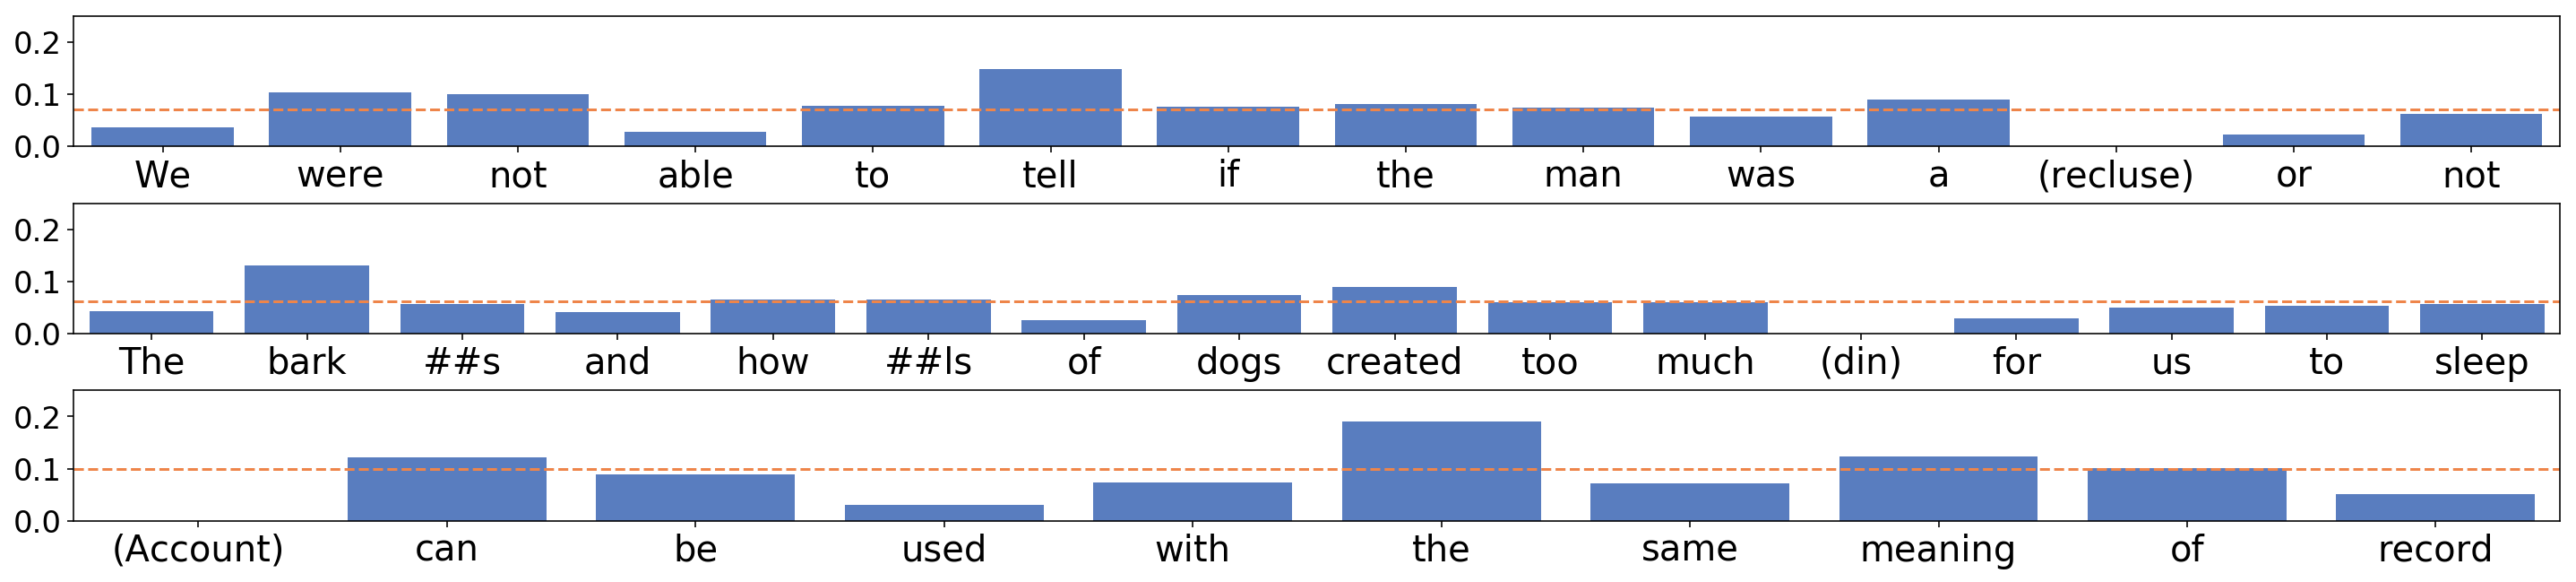

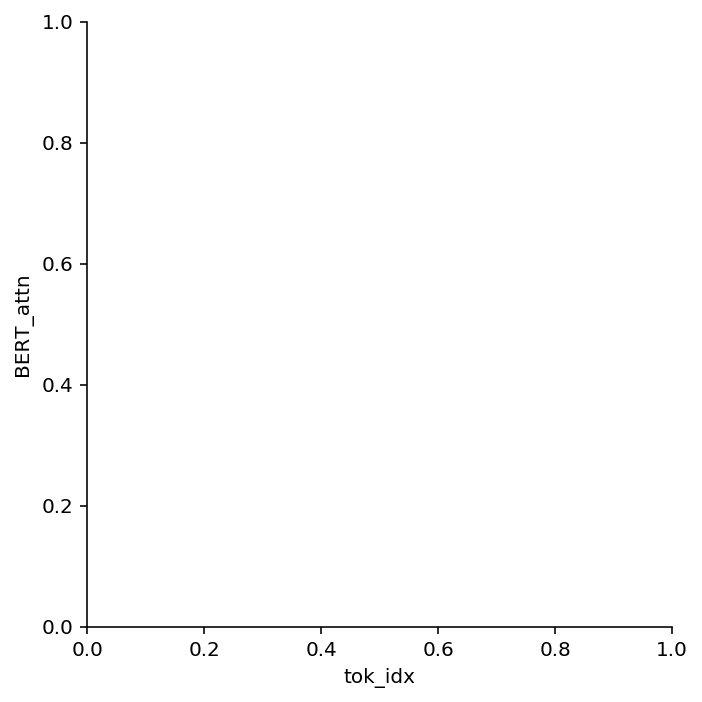

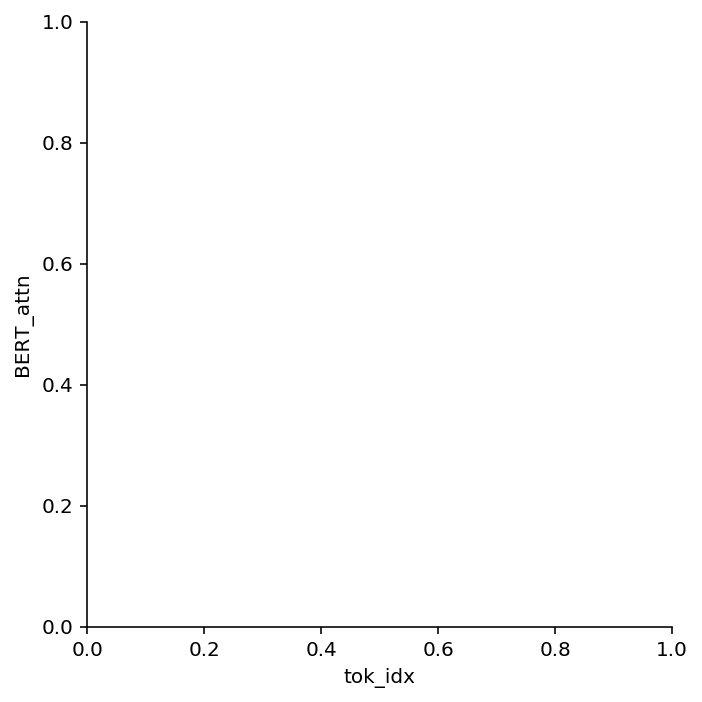

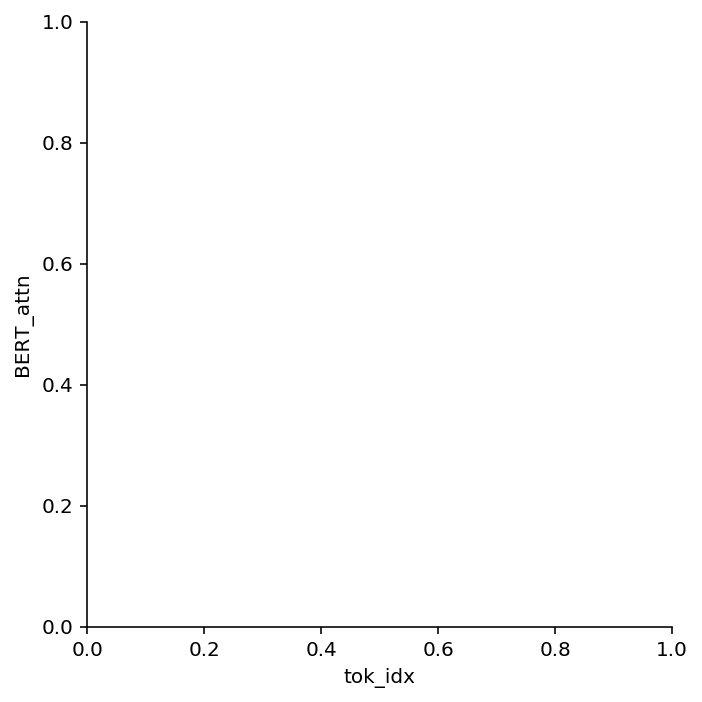

In [91]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(tt_df.shape[0], 1, figsize=(20, tt_df.shape[0]*1.5))
fig.tight_layout()
# fig.subplots_adjust(top=2, wspace=0.05)

colors = sns.color_palette('muted')

for i in range(tt_df.shape[0]):
    _df = tt_df_attn[tt_df_attn['sent_idx']==i]
    sns.catplot(x='tok_idx', y='BERT_attn', #hue='variable',
                kind="bar", #palette="muted",
                color=colors[0],
                data=_df,
                ax=ax[i])
    ax[i].set_ylim(0, 0.25)
    ax[i].axhline(1/_df.shape[0], ls='--', color=colors[1])
#     if(i < 2):
#         ax[i].set_ylim(0, 0.3)
#     else:
#         ax[i].set_ylim(0, 0.4)
    [ytick.label.set_fontsize(17) for ytick in ax[i].yaxis.get_major_ticks()]
    ax[i].set_ylabel("", fontsize=20)

    ax[i].set_xlabel("")
    ax[i].set_xticklabels(_df['tok'], fontsize=20)
    
# for i in range(2, 4):
#     sns.catplot(x='tok_idx', y='BERT_attn',
#                 kind="bar", palette="muted",
#                 data=tt_df_attn[tt_df_attn['sent_idx']==i],
#                 ax=ax[i])
#     ax[i].set_ylim(0, 0.5)
#     ax[i].set_xlabel("")
#     ax[i].set_ylabel("")
#     ax[i].set_xticklabels(tt_df_attn[tt_df_attn['sent_idx']==i]['tok'])
    
# ax[0].set_title("Synonym", fontsize=20)
# ax[1].set_title("Causal", fontsize=20)
# ax[2].set_title("Antonym", fontsize=20)

# fig.savefig("result3_summary_examplesent.png", dpi=300, bbox_inches = 'tight')

In [92]:
# %config InlineBackend.figure_format = 'retina'

# fig, axes = plt.subplots(2, 2, figsize=(28, 10))
# _width=0.35

# axes[0][0].bar(x=tt_sent_elmo[1][0][:tt_sent_elmo[0][0]], height=tt_attn_elmo[0][:tt_sent[0][0]], label="ELMo")
# axes[0][1].bar(x=tt_sent_elmo[1][1][:tt_sent_elmo[0][1]], height=tt_attn_elmo[1][:tt_sent[0][1]], label="ELMo")
# axes[1][0].bar(x=tokenizer.convert_ids_to_tokens(tt_sent_bert_input[0][0])+_width, height=tt_attn_bert[0], label="BERT")
# axes[1][1].bar(x=tokenizer.convert_ids_to_tokens(tt_sent_bert_input[0][1])+_width, height=tt_attn_bert[1], label="BERT")

# # axes[0][0].set_title("elmo_finetune_dscovar")
# # axes[0][1].set_title("elmo_finetune_kapelner")
# # axes[1][0].set_title("bert_finetune_dscovar")
# # axes[1][1].set_title("bert_finetune_kapelner")
# for ax in axes:
#     for axx in ax:
#         axx.set_ylim(0, 0.25)
# fig.savefig("result3_summary_examplesent.png", dpi=300)

# comparing finetune vs notune models
- comparing attention weight ranks
- both uses attention block
- if the finetune model perform better: substantial interaction is going on between finetuning and attention
    - attention block is helpful for training the better model overall

In [93]:
elmo_fntune_kap_attscore_pair = [np.mean(attention_ranks(elmo_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[4][i])) for i in range(df_eval.shape[0])]
elmo_fntune_kap_attscore_rcue = [np.mean(attention_ranks(elmo_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[5][i])) for i in range(df_eval.shape[0])]
elmo_fntune_dsc_attscore_pair = [np.mean(attention_ranks(elmo_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[4][i])+1) for i in range(df_eval.shape[0])]
elmo_fntune_dsc_attscore_rcue = [np.mean(attention_ranks(elmo_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[5][i])+1) for i in range(df_eval.shape[0])]

In [94]:
bert_fntune_kap_attscore_pair = [np.mean(attention_ranks(bert_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[4][i])) for i in range(df_eval.shape[0])]
bert_fntune_kap_attscore_rcue = [np.mean(attention_ranks(bert_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[5][i])) for i in range(df_eval.shape[0])]
bert_fntune_dsc_attscore_pair = [np.mean(attention_ranks(bert_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[4][i])+1) for i in range(df_eval.shape[0])]
bert_fntune_dsc_attscore_rcue = [np.mean(attention_ranks(bert_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[5][i])+1) for i in range(df_eval.shape[0])]

In [95]:
df_eval_res = df_eval.copy()
df_eval_res["ELMo_fntune_pair"]=(1-(elmo_fntune_kap_attscore_pair/(sentences_notarg[0]-1)))
df_eval_res["ELMo_fntune_rcue"]=(1-(elmo_fntune_kap_attscore_rcue/(sentences_notarg[0]-1)))
df_eval_res["BERT_fntune_pair"]=(1-(bert_fntune_kap_attscore_pair/(sentences_notarg[0]-1)))
df_eval_res["BERT_fntune_rcue"]=(1-(bert_fntune_kap_attscore_rcue/(sentences_notarg[0]-1)))
df_eval_res["random_pair"]=[1-(np.random.choice(sentences_notarg[0][i])/(sentences_notarg[0][i]-1)) for i in range(df_eval.shape[0])]
df_eval_res["random_rcue"]=[1-(np.random.choice(sentences_notarg[0][i])/(sentences_notarg[0][i]-1)) for i in range(df_eval.shape[0])]

In [96]:
np.mean([np.random.choice(5) for i in range(100)])

1.94

In [97]:
np.mean([(sentences_notarg[0][i]-np.random.choice(sentences_notarg[0][i]))/sentences_notarg[0][i] for i in range(df_eval.shape[0])])

0.5720706367696491

In [98]:
# df_eval_res_pair = df_eval_res[["random_pair",# "random_rcue", 
#                                 #"BERT_notune_pair",# "BERT_notune_rcue",
#                                 "BERT_fntune_pair",# "BERT_fntune_rcue",
#                                 "relation"]]
# df_eval_res_rcue = df_eval_res[["random_rcue",# "random_rcue", 
#                                 #"BERT_notune_rcue",# "BERT_notune_rcue",
#                                 "BERT_fntune_rcue",# "BERT_fntune_rcue",
#                                 "relation"]]
df_eval_res = df_eval_res[["random_rcue",
                           "BERT_fntune_pair",
                           "BERT_fntune_rcue",
                           "relation"]]

In [99]:
tt_res_ord = pd.DataFrame(
    {'bert-rdm':df_eval_res.groupby('relation').apply(lambda df:(df['BERT_fntune_pair']-df['random_rcue']).mean())})
tt_res_ord.reset_index(level=0, inplace=True)
tt_res_ord = tt_res_ord.sort_values('bert-rdm')
tt_res_ord
# tt_res = pd.DataFrame(
#     {'BERT+Att (Multi)':res_eval['bert_fntune_kap_attscore_avg'].tolist(),
#     'Relations':res_eval.index.tolist()}
# )

# tt_res = tt_res.iloc[:9].sort_values("BERT+Att (Multi)")
# # tt_res = pd.concat([tt_res.iloc[:9].sort_values("BERT+Att (Multi)"), tt_res.iloc[-1:]], axis=0)
# # tt_res = tt_res.reset_index()
# tt_res

,relation,bert-rdm
8,Synonym,-0.236819
0,Antonym,-0.118944
1,Entails,-0.045768
3,HasProperty,0.068980
2,HasA,0.071910
7,PartOf,0.129154
4,IsA,0.143279
5,MadeOf,0.253260
6,MemberOf,0.275000


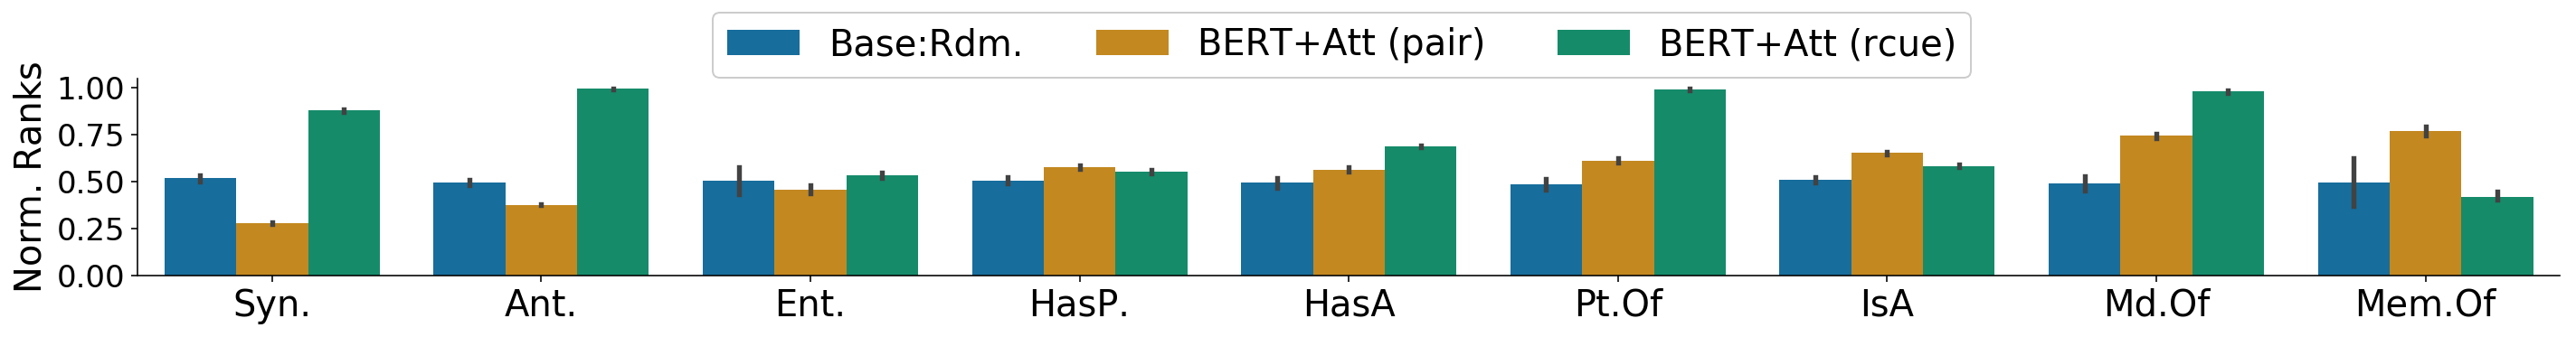

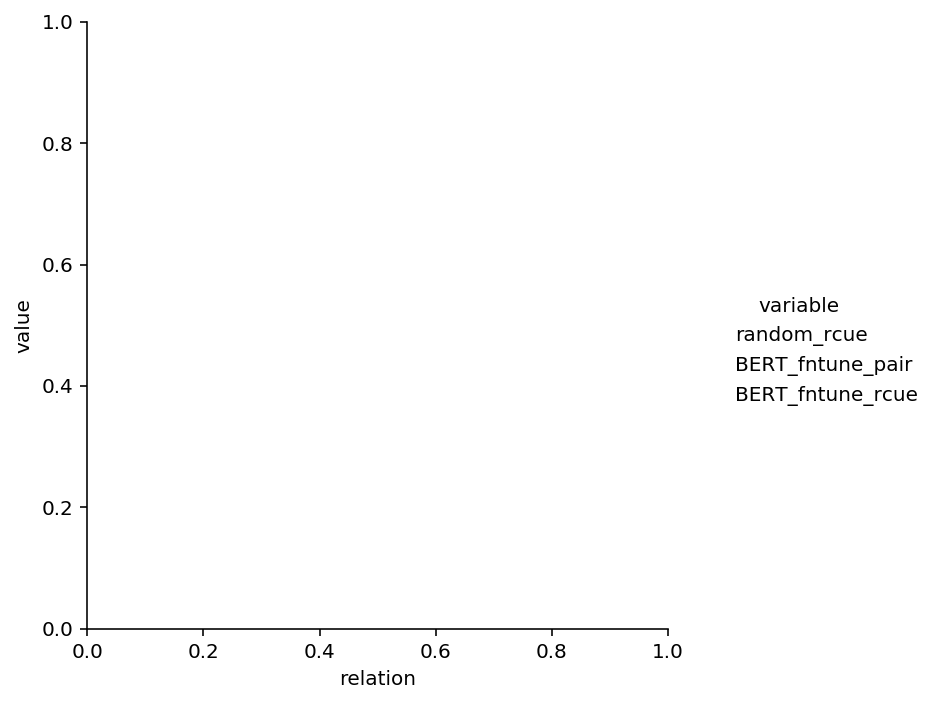

In [101]:
tt_pair_rcue = pd.melt(df_eval_res, id_vars='relation')

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(24, 2))
sns.catplot(x='relation', y='value', hue='variable', data=tt_pair_rcue,
            kind="bar", palette="colorblind", order=tt_res_ord['relation'],
            ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#     axx.set_ylim(0,0.8)

[ytick.label.set_fontsize(17) for ytick in ax.yaxis.get_major_ticks()]
[xtick.label.set_fontsize(20) for xtick in ax.xaxis.get_major_ticks()]

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(0.23, 1.17),
           ncol=3, fontsize=20,
           labels=['Base:Rdm.', 'BERT+Att (pair)', 'BERT+Att (rcue)'],
           facecolor='white', framealpha=1.0)


ax.set_ylabel("Norm. Ranks", fontsize=20)

ax.set_xlabel("", fontsize=20)
ax.set_xticklabels(['Syn.', 'Ant.', 'Ent.', "HasP.", 'HasA', 'Pt.Of', 'IsA', 'Md.Of', 'Mem.Of'], 
                   fontsize=20)


# # ax[0].set_title("Pair Words")

# # ax.set_xticklabels(, 
# #                    fontsize=18)

fig.savefig("result3_bert_pair_rcue_wider.pdf", dpi=300, bbox_inches = 'tight')
# # ax[0].savefig("result3_bert_pair.png", dpi=300, bbox_inches = 'tight')
# # ax[1].savefig("result3_bert_rcue.png", dpi=300, bbox_inches = 'tight')

## results: multi-sentence trained model 

In [351]:
df_eval_res_summary=pd.DataFrame(
    {"ELMo_fntune_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["ELMo_fntune_pair"], digits=3)),
     "ELMo_fntune_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["ELMo_fntune_rcue"], digits=3)),
     "BERT_fntune_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["BERT_fntune_pair"], digits=3)),
     "BERT_fntune_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["BERT_fntune_rcue"], digits=3)),
     "random_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["random_pair"], digits=3)),
     "random_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["random_rcue"], digits=3))})

In [352]:
df_eval_res_summary.loc['Overall Avg.']=[ci(df_eval_res["ELMo_fntune_pair"], digits=3),
                                        ci(df_eval_res["ELMo_fntune_rcue"], digits=3),
#                                         ci(df_eval_res["ELMo_notune_pair"], digits=3),
#                                         ci(df_eval_res["ELMo_notune_rcue"], digits=3),
                                        ci(df_eval_res["BERT_fntune_pair"], digits=3),
                                        ci(df_eval_res["BERT_fntune_rcue"], digits=3),
#                                         ci(df_eval_res["BERT_notune_pair"], digits=3),
#                                         ci(df_eval_res["BERT_notune_rcue"], digits=3),
                                        ci(df_eval_res["random_pair"], digits=3),
                                        ci(df_eval_res["random_rcue"], digits=3)]
df_eval_res_summary.reset_index(level=0, inplace=True)

In [353]:
df_eval_res_summary

,relation,ELMo_fntune_pair,ELMo_fntune_rcue,BERT_fntune_pair,BERT_fntune_rcue,random_pair,random_rcue
0,Antonym,"(0.505, 0.504, 0.507)","(0.253, 0.251, 0.254)","(0.376, 0.375, 0.376)","(0.994, 0.992, 0.996)","(0.504, 0.488, 0.52)","(0.522, 0.506, 0.538)"
1,Entails,"(0.954, 0.919, 0.989)","(0.394, 0.377, 0.411)","(0.456, 0.433, 0.479)","(0.533, 0.518, 0.548)","(0.424, 0.354, 0.495)","(0.538, 0.466, 0.609)"
2,HasA,"(0.31, 0.304, 0.317)","(0.758, 0.755, 0.762)","(0.563, 0.55, 0.576)","(0.686, 0.682, 0.689)","(0.507, 0.478, 0.535)","(0.49, 0.461, 0.519)"
3,HasProperty,"(0.998, 0.996, 1.0)","(0.209, 0.205, 0.212)","(0.574, 0.565, 0.583)","(0.55, 0.542, 0.559)","(0.488, 0.469, 0.506)","(0.504, 0.486, 0.523)"
4,IsA,"(0.99, 0.987, 0.993)","(0.212, 0.209, 0.215)","(0.65, 0.643, 0.658)","(0.581, 0.574, 0.588)","(0.499, 0.483, 0.515)","(0.5, 0.484, 0.515)"
5,MadeOf,"(0.998, 0.995, 1.001)","(0.692, 0.681, 0.704)","(0.743, 0.73, 0.755)","(0.977, 0.968, 0.986)","(0.476, 0.437, 0.515)","(0.482, 0.444, 0.521)"
6,MemberOf,"(0.994, 0.981, 1.006)","(0.2, 0.2, 0.2)","(0.769, 0.742, 0.795)","(0.419, 0.397, 0.44)","(0.494, 0.372, 0.615)","(0.494, 0.355, 0.632)"
7,PartOf,"(0.995, 0.992, 0.998)","(0.705, 0.697, 0.712)","(0.611, 0.601, 0.622)","(0.99, 0.986, 0.995)","(0.511, 0.483, 0.539)","(0.503, 0.476, 0.53)"
8,Synonym,"(0.777, 0.775, 0.78)","(0.235, 0.231, 0.239)","(0.279, 0.274, 0.283)","(0.876, 0.871, 0.882)","(0.495, 0.477, 0.514)","(0.508, 0.488, 0.527)"
9,Overall Avg.,"(0.808, 0.802, 0.814)","(0.328, 0.324, 0.333)","(0.517, 0.513, 0.521)","(0.766, 0.76, 0.771)","(0.497, 0.49, 0.505)","(0.506, 0.498, 0.513)"


## results: single-sentence trained model 

In [356]:
df_eval_res = df_eval.copy()
df_eval_res["ELMo_fntune_pair"]=(1-(elmo_fntune_dsc_attscore_pair/(sentences_notarg[0]-1)))
df_eval_res["ELMo_fntune_rcue"]=(1-(elmo_fntune_dsc_attscore_rcue/(sentences_notarg[0]-1)))
df_eval_res["BERT_fntune_pair"]=(1-(bert_fntune_dsc_attscore_pair/(sentences_notarg[0]-1)))
df_eval_res["BERT_fntune_rcue"]=(1-(bert_fntune_dsc_attscore_rcue/(sentences_notarg[0]-1)))
df_eval_res["random_pair"]=[1-(np.random.choice(sentences_notarg[0][i])/(sentences_notarg[0][i]-1)) for i in range(df_eval.shape[0])]
df_eval_res["random_rcue"]=[1-(np.random.choice(sentences_notarg[0][i])/(sentences_notarg[0][i]-1)) for i in range(df_eval.shape[0])]

In [359]:
df_eval_res_summary=pd.DataFrame(
    {"ELMo_fntune_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["ELMo_fntune_pair"], digits=3)),
     "ELMo_fntune_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["ELMo_fntune_rcue"], digits=3)),
     "BERT_fntune_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["BERT_fntune_pair"], digits=3)),
     "BERT_fntune_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["BERT_fntune_rcue"], digits=3)),
     "random_pair":df_eval_res.groupby('relation').apply(lambda df:ci(df["random_pair"], digits=3)),
     "random_rcue":df_eval_res.groupby('relation').apply(lambda df:ci(df["random_rcue"], digits=3))})

In [360]:
df_eval_res_summary.loc['Overall Avg.']=[ci(df_eval_res["ELMo_fntune_pair"], digits=3),
                                        ci(df_eval_res["ELMo_fntune_rcue"], digits=3),
                                        ci(df_eval_res["BERT_fntune_pair"], digits=3),
                                        ci(df_eval_res["BERT_fntune_rcue"], digits=3),
                                        ci(df_eval_res["random_pair"], digits=3),
                                        ci(df_eval_res["random_rcue"], digits=3)]
df_eval_res_summary.reset_index(level=0, inplace=True)

In [361]:
df_eval_res_summary

,relation,ELMo_fntune_pair,ELMo_fntune_rcue,BERT_fntune_pair,BERT_fntune_rcue,random_pair,random_rcue
0,Antonym,"(0.727, 0.724, 0.73)","(0.603, 0.599, 0.606)","(0.45, 0.445, 0.455)","(0.561, 0.555, 0.566)","(0.507, 0.491, 0.523)","(0.494, 0.478, 0.51)"
1,Entails,"(0.364, 0.346, 0.382)","(0.21, 0.183, 0.237)","(0.091, 0.056, 0.126)","(0.32, 0.3, 0.341)","(0.482, 0.414, 0.55)","(0.452, 0.38, 0.524)"
2,HasA,"(0.509, 0.504, 0.515)","(0.257, 0.252, 0.261)","(0.493, 0.485, 0.501)","(0.105, 0.1, 0.11)","(0.485, 0.457, 0.513)","(0.507, 0.479, 0.535)"
3,HasProperty,"(0.405, 0.403, 0.408)","(0.795, 0.794, 0.797)","(0.046, 0.04, 0.051)","(0.18, 0.173, 0.186)","(0.498, 0.479, 0.516)","(0.507, 0.489, 0.525)"
4,IsA,"(0.4, 0.397, 0.403)","(0.795, 0.793, 0.796)","(0.006, 0.004, 0.008)","(0.242, 0.238, 0.247)","(0.508, 0.492, 0.523)","(0.502, 0.487, 0.517)"
5,MadeOf,"(0.504, 0.499, 0.51)","(0.259, 0.253, 0.265)","(0.559, 0.541, 0.577)","(0.023, 0.013, 0.033)","(0.55, 0.512, 0.587)","(0.487, 0.446, 0.527)"
6,MemberOf,"(0.4, 0.4, 0.4)","(0.8, 0.8, 0.8)","(0.006, -0.006, 0.019)","(0.325, 0.29, 0.36)","(0.425, 0.307, 0.543)","(0.494, 0.375, 0.612)"
7,PartOf,"(0.504, 0.501, 0.507)","(0.25, 0.248, 0.252)","(0.235, 0.221, 0.249)","(0.178, 0.162, 0.194)","(0.501, 0.473, 0.529)","(0.476, 0.449, 0.502)"
8,Synonym,"(0.771, 0.768, 0.774)","(0.477, 0.473, 0.481)","(0.331, 0.328, 0.334)","(0.625, 0.619, 0.631)","(0.493, 0.474, 0.512)","(0.503, 0.484, 0.522)"
9,Overall Avg.,"(0.546, 0.542, 0.549)","(0.592, 0.587, 0.597)","(0.235, 0.23, 0.24)","(0.331, 0.326, 0.336)","(0.503, 0.495, 0.51)","(0.498, 0.491, 0.506)"


In [71]:
[attention_ranks(elmo_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[4][7]), attention_ranks(elmo_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[5][7]),
 attention_ranks(elmo_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[4][7]), attention_ranks(elmo_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[5][7]),
 attention_ranks(bert_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[4][7]), attention_ranks(bert_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[5][7]),
 attention_ranks(bert_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[4][7]), attention_ranks(bert_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[5][7]),
]

[array([1]),
 array([4]),
 array([2]),
 array([7]),
 array([4]),
 array([3]),
 array([7]),
 array([2])]

In [72]:
[attention_scores(elmo_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(elmo_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(bert_fntune_attn_pred_dsc[7], sentences_notarg[0][7], sentences_notarg[4][7], sentences_notarg[5][7]),
 attention_scores(bert_fntune_attn_pred_kap[7], sentences_notarg[0][7], sentences_notarg[4][7], sentences_notarg[5][7])
]

[array([0.9, 0.6]), array([0.8, 0.3]), array([0.6, 0.7]), array([0.3, 0.8])]

In [73]:
elmo_fntune_dsc_attscore = np.array([attention_scores(elmo_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
elmo_fntune_kap_attscore = np.array([attention_scores(elmo_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
bert_fntune_dsc_attscore = np.array([attention_scores(bert_fntune_attn_pred_dsc[i], sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
bert_fntune_kap_attscore = np.array([attention_scores(bert_fntune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
# bert_notune_kap_attscore = np.array([attention_scores(bert_notune_attn_pred_kap[i], sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])

In [186]:
bert_fntune_dsc_attscore

array([[0.77777778, 0.66666667],
       [0.55555556, 0.77777778],
       [0.77777778, 0.55555556],
       ...,
       [0.57142857, 0.35714286],
       [0.55555556, 0.66666667],
       [0.33333333, 0.5       ]])

In [84]:
sentences_notarg[0][0]

9

In [202]:
pd.Series([1,2,5,4, 2]).rank(method='average', ascending=False).values

array([5. , 3.5, 1. , 2. , 3.5])

In [194]:
np.argsort([1,2,5,4])

array([0, 1, 3, 2])

In [195]:
np.argsort([1,2,5,4])[::-1]

array([2, 3, 1, 0])

In [252]:
# np.array([attention_scores(np.random.choice(sentences_notarg[0][i]), sentences_notarg[0][i], sentences_notarg[4][i], sentences_notarg[5][i]) for i in range(df_eval.shape[0])])
rdm_kap_score_pair = [((sentences_notarg[0][i]-np.random.choice(sentences_notarg[0][i]))/sentences_notarg[0][i]).mean() for i in range(df_eval.shape[0])]
rdm_kap_score_rcue = [((sentences_notarg[0][i]-np.random.choice(sentences_notarg[0][i]))/sentences_notarg[0][i]).mean() for i in range(df_eval.shape[0])]

In [253]:
df_eval['elmo_fntune_dsc_attscore_pair'] = elmo_fntune_dsc_attscore[:,0]
df_eval['elmo_fntune_dsc_attscore_rcue'] = elmo_fntune_dsc_attscore[:,1]
df_eval['elmo_fntune_kap_attscore_pair'] = elmo_fntune_kap_attscore[:,0]
df_eval['elmo_fntune_kap_attscore_rcue'] = elmo_fntune_kap_attscore[:,1]
df_eval['bert_fntune_dsc_attscore_pair'] = bert_fntune_dsc_attscore[:,0]
df_eval['bert_fntune_dsc_attscore_rcue'] = bert_fntune_dsc_attscore[:,1]
df_eval['bert_fntune_kap_attscore_pair'] = bert_fntune_kap_attscore[:,0]
df_eval['bert_fntune_kap_attscore_rcue'] = bert_fntune_kap_attscore[:,1]
# df_eval['bert_notune_kap_attscore_pair'] = bert_notune_kap_attscore[:,0]
# df_eval['bert_notune_kap_attscore_rcue'] = bert_notune_kap_attscore[:,1]
df_eval['rdm_kap_pair'] = rdm_kap_score_pair
df_eval['rdm_kap_rcue'] = rdm_kap_score_rcue

df_eval['elmo_fntune_dsc_attscore_avg'] = (df_eval['elmo_fntune_dsc_attscore_pair']+df_eval['elmo_fntune_dsc_attscore_rcue'])/2
df_eval['elmo_fntune_kap_attscore_avg'] = (df_eval['elmo_fntune_kap_attscore_pair']+df_eval['elmo_fntune_kap_attscore_rcue'])/2
df_eval['bert_fntune_dsc_attscore_avg'] = (df_eval['bert_fntune_dsc_attscore_pair']+df_eval['bert_fntune_dsc_attscore_rcue'])/2
df_eval['bert_fntune_kap_attscore_avg'] = (df_eval['bert_fntune_kap_attscore_pair']+df_eval['bert_fntune_kap_attscore_rcue'])/2
df_eval['rdm_kap_avg'] = (df_eval['rdm_kap_pair']+df_eval['rdm_kap_rcue'])/2
# df_eval['bert_notune_kap_attscore_avg'] = (df_eval['bert_notune_kap_attscore_pair']+df_eval['bert_notune_kap_attscore_rcue'])/2

In [254]:
# df_eval_res_pair = df_eval[["rdm_kap_pair",# "random_rcue", 
#                                 #"BERT_notune_pair",# "BERT_notune_rcue",
#                                 "bert_fntune_kap_attscore_pair",# "BERT_fntune_rcue",
#                                 "relation"]]
# df_eval_res_rcue = df_eval[["rdm_kap_rcue",# "random_rcue", 
#                                 #"BERT_notune_rcue",# "BERT_notune_rcue",
#                                 "bert_fntune_kap_attscore_rcue",# "BERT_fntune_rcue",
#                                 "relation"]]

df_eval_res = df_eval[["rdm_kap_pair",# "random_rcue", 
                       "bert_fntune_kap_attscore_pair",
                       "bert_fntune_kap_attscore_rcue",
                       "relation"]]


In [255]:
tt_res_ord = pd.DataFrame(
    {'bert-rdm':df_eval_res.groupby('relation').apply(lambda df:(df['bert_fntune_kap_attscore_pair']-df['rdm_kap_pair']).mean())})
tt_res_ord.reset_index(level=0, inplace=True)
tt_res_ord = tt_res_ord.sort_values('bert-rdm')
tt_res_ord
# tt_res = pd.DataFrame(
#     {'BERT+Att (Multi)':res_eval['bert_fntune_kap_attscore_avg'].tolist(),
#     'Relations':res_eval.index.tolist()}
# )

# tt_res = tt_res.iloc[:9].sort_values("BERT+Att (Multi)")
# # tt_res = pd.concat([tt_res.iloc[:9].sort_values("BERT+Att (Multi)"), tt_res.iloc[-1:]], axis=0)
# # tt_res = tt_res.reset_index()
# tt_res

,relation,bert-rdm
8,Synonym,-0.211024
0,Antonym,-0.117744
1,Entails,-0.051716
2,HasA,0.054294
3,HasProperty,0.058312
7,PartOf,0.089939
4,IsA,0.131213
5,MadeOf,0.182056
6,MemberOf,0.255208


In [328]:
# tt_pair_rcue = pd.melt(df_eval_res, id_vars='relation')

# %config InlineBackend.figure_format = 'retina'

# fig, ax = plt.subplots(1, 1, figsize=(12, 3))
# sns.catplot(x='relation', y='value', hue='variable', data=tt_pair_rcue,
#             kind="bar", palette="muted", order=tt_res_ord['relation'],
#             ax=ax)

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# #     axx.set_ylim(0,0.8)

# [ytick.label.set_fontsize(17) for ytick in ax.yaxis.get_major_ticks()]
# [xtick.label.set_fontsize(20) for xtick in ax.xaxis.get_major_ticks()]

# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles=handles, loc='center left', bbox_to_anchor=(0.23, 1.1),
#            ncol=3, fontsize=15,
#            labels=['Base:Rdm.', 'BERT+Att (pair)', 'BERT+Att (rcue)'],
#            facecolor='white', framealpha=1.0)


# ax.set_ylabel("Norm. Ranks", fontsize=20)

# ax.set_xlabel("", fontsize=20)
# ax.set_xticklabels(['Syn.', 'Ant.', 'Ent.', "HasP.", 'HasA', 'Pt.Of', 'IsA', 'Md.Of', 'Mem.Of'], 
#                    fontsize=20)


# # # ax[0].set_title("Pair Words")

# # # ax.set_xticklabels(, 
# # #                    fontsize=18)

# fig.savefig("result3_bert_pair_rcue.pdf", dpi=300, bbox_inches = 'tight')
# # # ax[0].savefig("result3_bert_pair.png", dpi=300, bbox_inches = 'tight')
# # # ax[1].savefig("result3_bert_rcue.png", dpi=300, bbox_inches = 'tight')

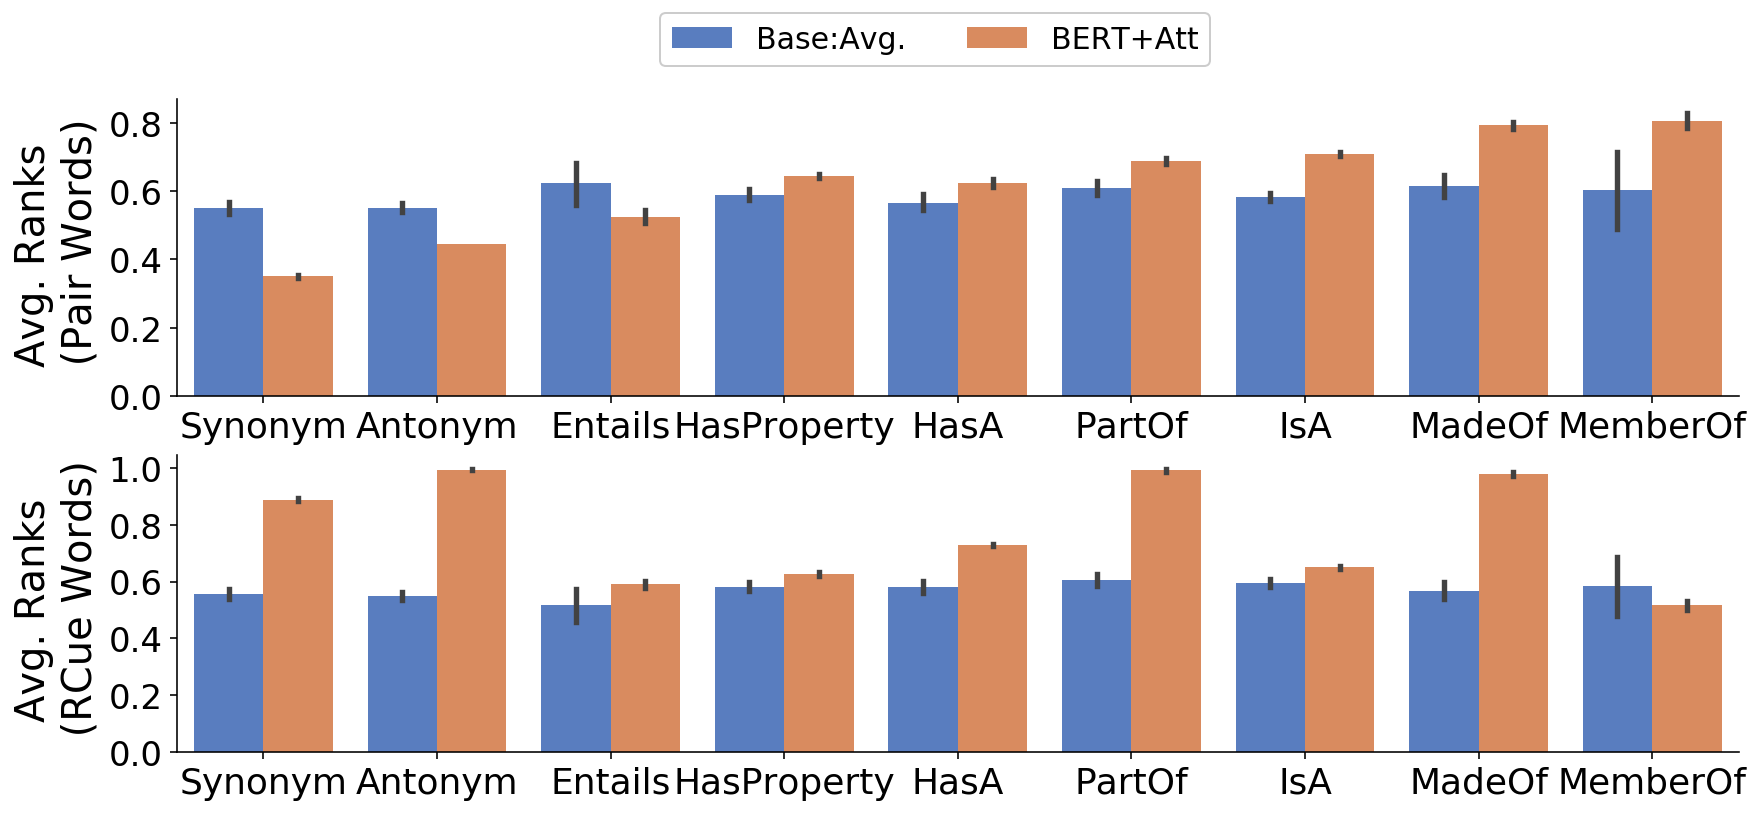

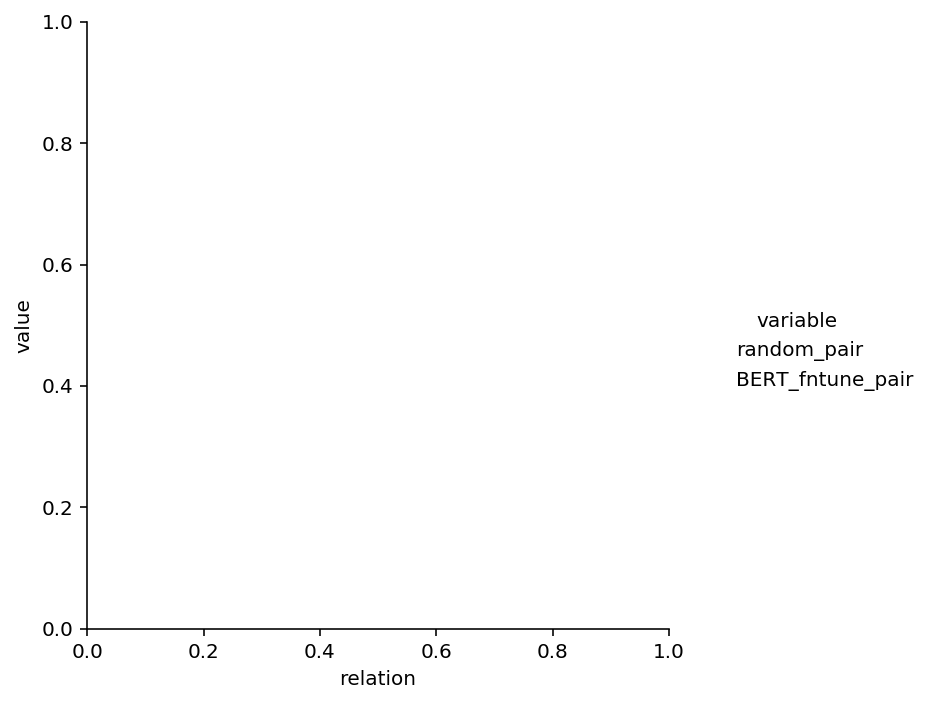

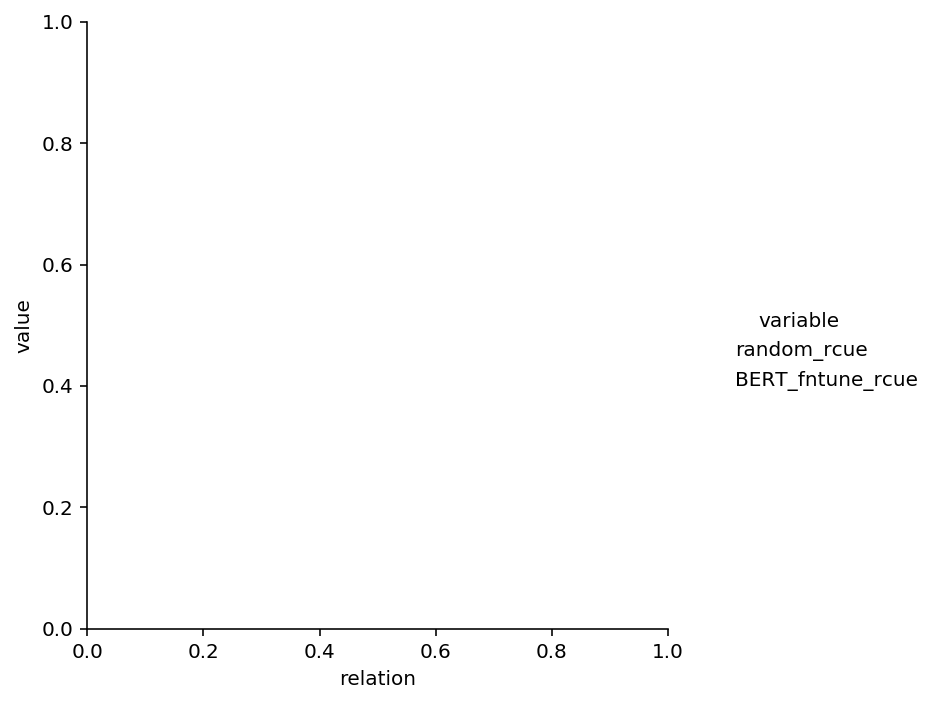

In [222]:
tt_pair = pd.melt(df_eval_res_pair, id_vars='relation')
tt_rcue = pd.melt(df_eval_res_rcue, id_vars='relation')

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(2, 1, figsize=(14, 6))
sns.catplot(x='relation', y='value', hue='variable', data=tt_pair,
            kind="bar", palette="muted", order=tt_res_ord['relation'],
            ax=ax[0])
sns.catplot(x='relation', y='value', hue='variable', data=tt_rcue,
            kind="bar", palette="muted", order=tt_res_ord['relation'],
            ax=ax[1])

for axx in ax:
    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)
#     axx.set_ylim(0,0.8)

    [ytick.label.set_fontsize(17) for ytick in axx.yaxis.get_major_ticks()]
    [xtick.label.set_fontsize(18) for xtick in axx.xaxis.get_major_ticks()]

handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, loc='center left', bbox_to_anchor=(0.3, 1.2),
           ncol=2, fontsize=15,
           labels=['Base:Avg.', 'BERT+Att'],
           facecolor='white', framealpha=1.0)
ax[1].get_legend().remove()


ax[0].set_ylabel("Avg. Ranks \n (Pair Words)", fontsize=20)
ax[1].set_ylabel("Avg. Ranks \n (RCue Words)", fontsize=20)

ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("", fontsize=20)

# ax[0].set_title("Pair Words")

# ax.set_xticklabels(, 
#                    fontsize=18)

fig.savefig("result3_bert_pair_rcue.png", dpi=300, bbox_inches = 'tight')
# ax[0].savefig("result3_bert_pair.png", dpi=300, bbox_inches = 'tight')
# ax[1].savefig("result3_bert_rcue.png", dpi=300, bbox_inches = 'tight')

- Score: pair < rcue
    - if context does not include the target word
        - Antonym, HasProperty, Synonym
    - if context does include the target word
        - Entails, MadeOf
- Score: no target < with target
    - target-pair word
        - IsA
    - relational cue
        - MadeOf

In [99]:
res_eval = df_eval.groupby('relation').apply(lambda df:df[['elmo_fntune_dsc_attscore_pair', 'elmo_fntune_dsc_attscore_rcue', 'elmo_fntune_dsc_attscore_avg',
                                                           'elmo_fntune_kap_attscore_pair', 'elmo_fntune_kap_attscore_rcue', 'elmo_fntune_kap_attscore_avg',
                                                           'bert_fntune_dsc_attscore_pair', 'bert_fntune_dsc_attscore_rcue', 'bert_fntune_dsc_attscore_avg',
                                                           'bert_fntune_kap_attscore_pair', 'bert_fntune_kap_attscore_rcue', 'bert_fntune_kap_attscore_avg',
                                                           'rdm_kap_pair', 'rdm_kap_rcue', 'rdm_kap_avg'
                                                    ]].mean())
# tt.loc['sum'] = tt.sum(axis=0)
res_eval.loc['Overall Avg.'] = [df_eval['elmo_fntune_dsc_attscore_pair'].mean(), df_eval['elmo_fntune_dsc_attscore_rcue'].mean(), df_eval['elmo_fntune_dsc_attscore_avg'].mean(),
                                df_eval['elmo_fntune_kap_attscore_pair'].mean(), df_eval['elmo_fntune_kap_attscore_rcue'].mean(), df_eval['elmo_fntune_kap_attscore_avg'].mean(),
                                df_eval['bert_fntune_dsc_attscore_pair'].mean(), df_eval['bert_fntune_dsc_attscore_rcue'].mean(), df_eval['bert_fntune_dsc_attscore_avg'].mean(),
                                df_eval['bert_fntune_kap_attscore_pair'].mean(), df_eval['bert_fntune_kap_attscore_rcue'].mean(), df_eval['bert_fntune_kap_attscore_avg'].mean(),
                                df_eval['rdm_kap_pair'].mean(), df_eval['rdm_kap_rcue'].mean(), df_eval['rdm_kap_avg'].mean(),
                               ]
res_eval.round(3)

,elmo_fntune_dsc_attscore_pair,elmo_fntune_dsc_attscore_rcue,elmo_fntune_dsc_attscore_avg,elmo_fntune_kap_attscore_pair,elmo_fntune_kap_attscore_rcue,elmo_fntune_kap_attscore_avg,bert_fntune_dsc_attscore_pair,bert_fntune_dsc_attscore_rcue,bert_fntune_dsc_attscore_avg,bert_fntune_kap_attscore_pair,bert_fntune_kap_attscore_rcue,bert_fntune_kap_attscore_avg,rdm_kap_pair,rdm_kap_rcue,rdm_kap_avg
relation,,,,,,,,,,,,,,,
Antonym,0.868,0.758,0.813,0.560,0.336,0.448,0.622,0.720,0.671,0.445,0.995,0.720,0.565,0.544,0.554
Entails,0.567,0.432,0.499,0.959,0.469,0.714,0.328,0.528,0.428,0.523,0.591,0.557,0.637,0.601,0.619
HasA,0.722,0.505,0.614,0.409,0.793,0.601,0.708,0.375,0.541,0.625,0.730,0.678,0.602,0.574,0.588
HasProperty,0.671,0.996,0.833,0.998,0.340,0.669,0.371,0.483,0.427,0.645,0.625,0.635,0.575,0.589,0.582
IsA,0.665,0.994,0.830,0.991,0.343,0.667,0.337,0.534,0.435,0.708,0.650,0.679,0.579,0.583,0.581
MadeOf,0.802,0.605,0.703,0.998,0.753,0.876,0.845,0.416,0.630,0.793,0.981,0.887,0.597,0.575,0.586
MemberOf,0.667,1.000,0.833,0.995,0.333,0.664,0.339,0.604,0.471,0.807,0.516,0.661,0.547,0.547,0.547
PartOf,0.801,0.598,0.699,0.996,0.763,0.879,0.586,0.540,0.563,0.688,0.992,0.840,0.602,0.597,0.599
Synonym,0.893,0.629,0.761,0.799,0.311,0.555,0.497,0.762,0.629,0.350,0.889,0.620,0.557,0.554,0.555


In [48]:
tt = res_eval.filter(regex='_avg')
tt.columns = ['ELMo+Att (Single)', 'ELMo+Att (Multi)', 'BERT+Att (Single)', 'BERT+Att (Multi)', 'BERT+Att (Multi-notune)']
tt['Relations'] = tt.index.tolist()
# tt.rename(columns={'index':'Relations'},inplace=True)

tt = tt.melt(id_vars=['Relations'])

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


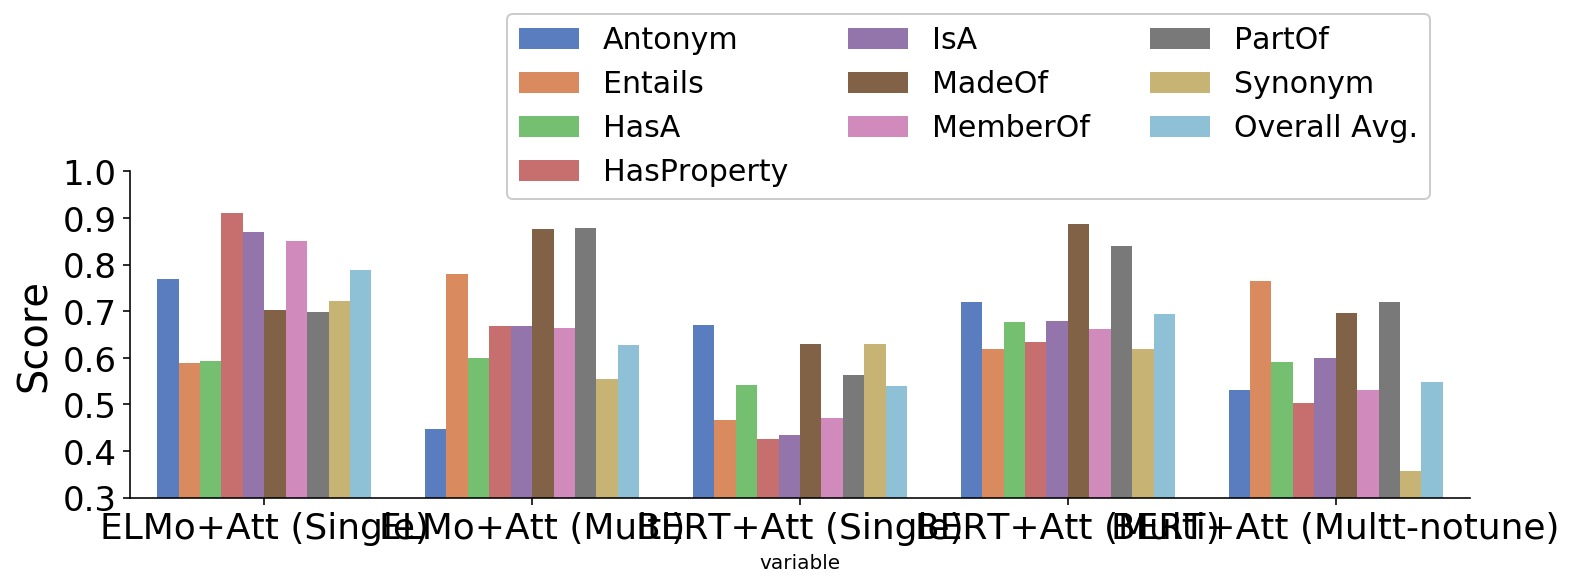

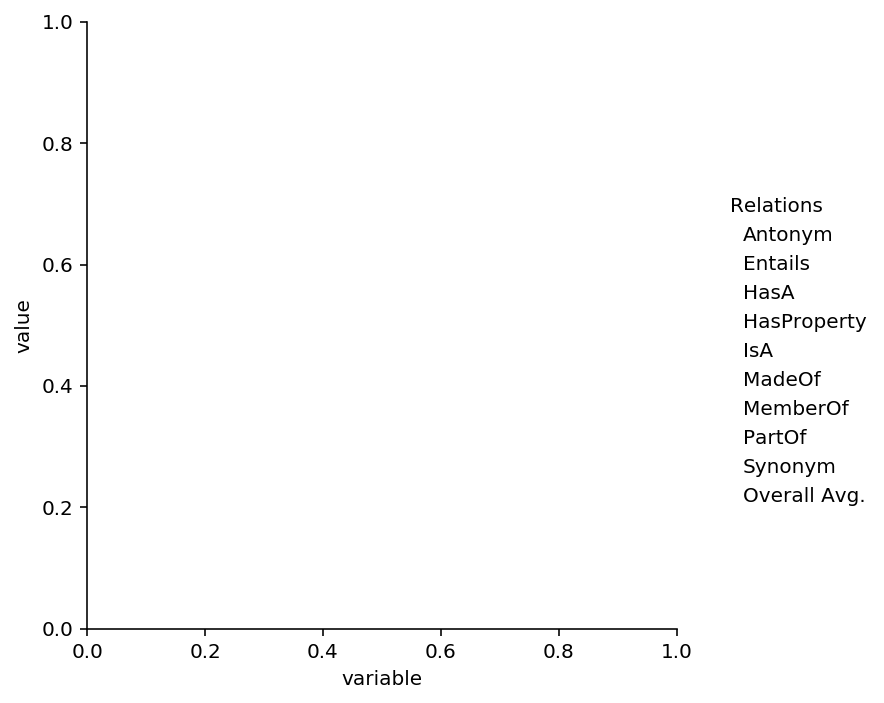

In [49]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

sns.catplot(x='variable', y='value', hue='Relations', data=tt,
            kind="bar", palette="muted", 
            ax=ax)
ax.set_ylim(0.3, 1)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.45), 
          ncol=1,
          facecolor='white', framealpha=1.0,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(0.27, 1.2),
            ncol=3, fontsize=15,
            facecolor='white', framealpha=1.0)

# ax.set_xlabel("Models")
ax.set_xticklabels(["ELMo+Att (Single)", "ELMo+Att (Multi)", "BERT+Att (Single)", "BERT+Att (Multi)", "BERT+Att (Multt-notune)"], 
                   fontsize=18)
[ytick.label.set_fontsize(17) for ytick in ax.yaxis.get_major_ticks()]
ax.set_ylabel("Score", fontsize=20)


fig.savefig("result3_summary.png", dpi=300, bbox_inches = 'tight')

Santus et al., 2015: The list of relationship and example relational cues
<img src="dataset/EVALution_1.0/santus_et_al__hearst.png">

In [100]:
pd.DataFrame({'BERT+Att (Multi)':[df_eval['bert_fntune_kap_attscore_avg'].mean()],
              'Relations': 'Overall Avg.'}, )

,BERT+Att (Multi),Relations
0,0.692861,Overall Avg.


In [101]:
# tt = df_eval[['relation', 'bert_fntune_kap_attscore_avg']]
tt = pd.DataFrame(
    {'BERT+Att (Multi)':df_eval['bert_fntune_kap_attscore_avg'].tolist(),
    'Relations':df_eval['relation']}
)
# tt = pd.concat([tt, 
#                 pd.DataFrame({'BERT+Att (Multi)':[df_eval['bert_fntune_kap_attscore_avg'].mean()],
#                               'Relations': 'Overall Avg.'})
#                ], ignore_index=True)

In [102]:
tt_res = pd.DataFrame(
    {'BERT+Att (Multi)':res_eval['bert_fntune_kap_attscore_avg'].tolist(),
    'Relations':res_eval.index.tolist()}
)

tt_res = tt_res.iloc[:9].sort_values("BERT+Att (Multi)")
# tt_res = pd.concat([tt_res.iloc[:9].sort_values("BERT+Att (Multi)"), tt_res.iloc[-1:]], axis=0)
# tt_res = tt_res.reset_index()
tt_res

,BERT+Att (Multi),Relations
1,0.557094,Entails
8,0.619506,Synonym
3,0.634867,HasProperty
6,0.661458,MemberOf
2,0.677841,HasA
4,0.679221,IsA
0,0.719669,Antonym
7,0.840149,PartOf
5,0.887228,MadeOf


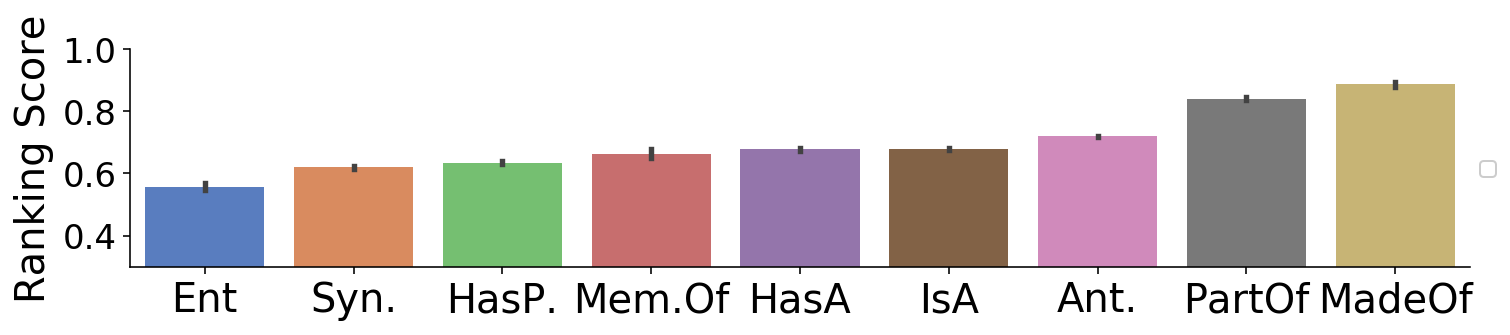

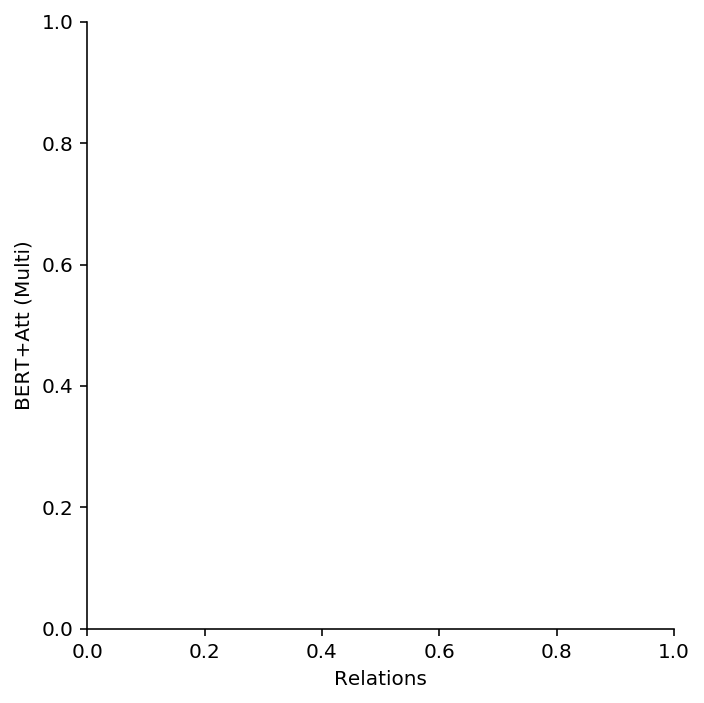

In [103]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(12, 2))

sns.catplot(x='Relations', y='BERT+Att (Multi)', order=tt_res['Relations'],
            data=tt,
            kind="bar", palette="muted", 
            ax=ax)
ax.set_ylim(0.3, 1)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.45), 
          ncol=1,
          facecolor='white', framealpha=1.0,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

[ytick.label.set_fontsize(17) for ytick in ax.yaxis.get_major_ticks()]
ax.set_ylabel("Ranking Score", fontsize=20)

ax.set_xlabel("")
ax.set_xticklabels(['Ent', 'Syn.', 'HasP.', "Mem.Of", 'HasA', 'IsA', 'Ant.', 'PartOf', 'MadeOf'], 
                   fontsize=20)


fig.savefig("result3_summary_bert_mult.png", dpi=300, bbox_inches = 'tight')

In [ ]:
tt = pd.DataFrame(
    {'BERT+Att (Multi)':res_eval['bert_fntune_kap_attscore_avg'].tolist(),
    'Relations':res_eval.index.tolist()}
)

In [ ]:
tt = pd.concat([tt.iloc[:9].sort_values("BERT+Att (Multi)"), tt.iloc[-1:]], axis=0)
tt = tt.reset_index()
tt

In [ ]:
tt = pd.DataFrame(
    {'BERT+Att (Multi)':res_eval['bert_fntune_kap_attscore_avg'].tolist(),
    'Relations':res_eval.index.tolist()}
)

In [ ]:
tt = pd.concat([tt.iloc[:9].sort_values("BERT+Att (Multi)"), tt.iloc[-1:]], axis=0)
tt = tt.reset_index()
tt

In [ ]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

sns.catplot(x='Relations', y='BERT+Att (Multi)',
            data=tt,
            kind="bar", palette="muted", 
            ax=ax)
ax.set_ylim(0.3, 1)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.45), 
          ncol=1,
          facecolor='white', framealpha=1.0,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

[ytick.label.set_fontsize(12) for ytick in ax.yaxis.get_major_ticks()]
ax.set_ylabel("Score", fontsize=15)

ax.set_xlabel("")
ax.set_xticklabels(['Ant.', 'Ent.', 'HasA', 'HasPrp.', 'IsA', 'Md.Of', 'Mem.Of', 'Pt.Of', 'Syn.', 'Overall'], 
                   fontsize=12)


# fig.savefig("result3_summary.png", dpi=300)

In [ ]:
res_eval_dsc = res_eval.filter(regex=('_dsc')).copy()
res_eval_dsc['bert-elmo'] = res_eval_dsc['bert_fntune_dsc_attscore_avg'] - res_eval_dsc['elmo_fntune_dsc_attscore_avg']
res_eval_dsc.sort_values(by='bert-elmo')

In [ ]:
res_eval_kap = res_eval.filter(regex=('_kap')).copy()
res_eval_kap['bert-elmo'] = res_eval_kap['bert_fntune_kap_attscore_avg'] - res_eval_kap['elmo_fntune_kap_attscore_avg']
res_eval_kap.sort_values(by='bert-elmo')

In [ ]:
res_eval_elmo = res_eval.filter(regex=('elmo')).copy()
res_eval_elmo['kap-dsc'] = res_eval_elmo['elmo_fntune_kap_attscore_avg'] - res_eval_elmo['elmo_fntune_dsc_attscore_avg']
res_eval_elmo.sort_values(by='kap-dsc').round(3)

In [ ]:
res_eval_bert = res_eval.filter(regex=('bert')).copy()
res_eval_bert['kap-dsc'] = res_eval_bert['bert_fntune_kap_attscore_avg'] - res_eval_bert['bert_fntune_dsc_attscore_avg']
res_eval_bert.sort_values(by='kap-dsc').round(3)

In [ ]:
# elmo finetune: dscovar vs kapelner
{"pair":(df_eval['elmo_fntune_dsc_attscore_pair'].mean(), df_eval['elmo_fntune_kap_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_dsc_attscore_pair'], df_eval['elmo_fntune_kap_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_dsc_attscore_rcue'].mean(), df_eval['elmo_fntune_kap_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_dsc_attscore_rcue'], df_eval['elmo_fntune_kap_attscore_rcue'])),
 "sum": (df_eval['elmo_fntune_dsc_attscore_avg'].mean(),  df_eval['elmo_fntune_kap_attscore_avg'].mean(),  ttest_ind(df_eval['elmo_fntune_dsc_attscore_avg'],  df_eval['elmo_fntune_kap_attscore_avg']))}

In [ ]:
# bert finetune: dscovar vs kapelner
{"pair":(df_eval['bert_fntune_dsc_attscore_pair'].mean(), df_eval['bert_fntune_kap_attscore_pair'].mean(), ttest_ind(df_eval['bert_fntune_dsc_attscore_pair'], df_eval['bert_fntune_kap_attscore_pair'])),
 "rcue":(df_eval['bert_fntune_dsc_attscore_rcue'].mean(), df_eval['bert_fntune_kap_attscore_rcue'].mean(), ttest_ind(df_eval['bert_fntune_dsc_attscore_rcue'], df_eval['bert_fntune_kap_attscore_rcue'])),
 "sum": (df_eval['bert_fntune_dsc_attscore_avg'].mean(),  df_eval['bert_fntune_kap_attscore_avg'].mean(),  ttest_ind(df_eval['bert_fntune_dsc_attscore_avg'],  df_eval['bert_fntune_kap_attscore_avg']))}

In [ ]:
# dscovar finetune: elmo vs bert
{"pair":(df_eval['elmo_fntune_dsc_attscore_pair'].mean(), df_eval['bert_fntune_dsc_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_dsc_attscore_pair'], df_eval['bert_fntune_dsc_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_dsc_attscore_rcue'].mean(), df_eval['bert_fntune_dsc_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_dsc_attscore_rcue'], df_eval['bert_fntune_dsc_attscore_rcue'])),
 "sum" :(df_eval['elmo_fntune_dsc_attscore_avg'].mean(),  df_eval['bert_fntune_dsc_attscore_avg'].mean(),  ttest_ind(df_eval['elmo_fntune_dsc_attscore_avg'],  df_eval['bert_fntune_dsc_attscore_avg']))}

In [ ]:
# kapelner finetune: elmo vs bert
{"pair":(df_eval['elmo_fntune_kap_attscore_pair'].mean(), df_eval['bert_fntune_kap_attscore_pair'].mean(), ttest_ind(df_eval['elmo_fntune_kap_attscore_pair'], df_eval['bert_fntune_kap_attscore_pair'])),
 "rcue":(df_eval['elmo_fntune_kap_attscore_rcue'].mean(), df_eval['bert_fntune_kap_attscore_rcue'].mean(), ttest_ind(df_eval['elmo_fntune_kap_attscore_rcue'], df_eval['bert_fntune_kap_attscore_rcue'])),
 "sum" :(df_eval['elmo_fntune_kap_attscore_avg'].mean(),  df_eval['bert_fntune_kap_attscore_avg'].mean(),  ttest_ind(df_eval['elmo_fntune_kap_attscore_avg'],  df_eval['bert_fntune_kap_attscore_avg']))}

In [ ]:
res_eval_elmo = res_eval.filter(regex=('elmo')).copy()
res_eval_elmo['kap-dsc'] = res_eval_elmo['elmo_fntune_kap_attscore_avg'] - res_eval_elmo['elmo_fntune_dsc_attscore_avg']
res_eval_elmo.sort_values(by='kap-dsc')

In [ ]:
# elmo finetune: dscovar vs kapelner - by relations
df_eval.groupby('relation').apply(
    lambda df:
    # tscore < 0: dsc > kap
     ttest_ind(df['elmo_fntune_kap_attscore_avg'], df['elmo_fntune_dsc_attscore_avg'])
)

In [ ]:
# TODO: check bert sentence preprocessing e.g., indexing for rcue and the pair words - currently sharing the elmo's